In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch

# Force reload modules  ## CAN BE REMOVED WHEN DONE
import importlib
importlib.reload(visualization)
importlib.reload(stats)
importlib.reload(data_processing)

<module 'data_processing' from '/scratch/jaap/SPVGazeAnalysis/gaze_analysis/./../data_processing.py'>

## Load data

In [3]:
# All data
# path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
path = '../../_Datasets/SPVGazeData/_preprocessed_org'
exp_data, calbr_data = data_processing.load_preprocessed_data(path)
subjects = data_processing.SUBJECTS # or specify subset of subjects
practice_trials = data_processing.PRACTICE_TRIALS

/scratch/jaap/SPVGazeAnalysis/gaze_analysis/./../data_processing.py:116: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_data[data_key] = pd.read_csv(os.path.join(path,fn),sep='\t')


In [4]:
eye_data = data_processing.drop_invalid(exp_data['SingleEyeDataRecordC'],
                                        exclude_trials = practice_trials,
                                        include_subjects = subjects,
                                        clip_valid_frames = True,
                                        check_sensor_validity=True)

eng_data = data_processing.drop_invalid(exp_data['EngineDataRecord'],
                        exclude_trials = practice_trials,
                        clip_valid_frames = True,
                        include_subjects = subjects)

trc_data = data_processing.drop_invalid(exp_data['TrialConfigRecord'],
                                        exclude_trials = practice_trials,
                                        include_subjects = subjects)

### Calculate gaze angles, velocity, etc.

In [5]:
def L2_norm(df):
    """returns the L2-Norm for each row in input dataframe."""
    return np.linalg.norm(df,axis=-1)

def angle_between(vec1,vec2):
    dot = (vec1*vec2).sum(axis=1)
    norm = L2_norm(vec1)*L2_norm(vec2)
    return np.arccos(dot/norm)

def calc_spread(gazedir):
    """returns the variance (in degrees) across rows in the dataframe. Here, columns should 
    be x,y,z coordinates of the normalized gaze direction and rows indicate different frames"""
    deviation_angle = angle_between(gazedir, gazedir.mean())*180/np.pi
    variance = deviation_angle.var()
    return variance

def calc_trial_endpoints(data, gaze_lbl='GazeDirectionNormInEye'):
    """Calculate several gaze endpoints for each trial, such as Variance, Velocity and Displacement. 
    Returns a dataframe that is indexed by trial. Note: performs inplace operations on input dataframe (drop invalids)"""

    # extract the gaze direction collumns (per trial)
    gaze_columns = [gaze_lbl + c for c in ['X', 'Y', 'Z']]
    grouped_by_trial = data.groupby(['TrialIdentifier'])
    gaze_dir = grouped_by_trial[gaze_columns]

    # Calc elapsed time, displacement and velocity per frame
    time_ = grouped_by_trial.SecondsSinceTrialStart
    data['DeltaTime'] = time_.diff()
    data['AngularDisplacement'] = angle_between(data[gaze_columns],grouped_by_trial[gaze_columns].shift(1)) *180/np.pi
    data['AngularVelocity'] = data.AngularDisplacement / data.DeltaTime
    
    # Calculate deviation from the trial average 
    avg_gaze_dir = grouped_by_trial[gaze_columns].mean().loc[data.TrialIdentifier]
    data['DeviationFromAverage'] = angle_between(data[gaze_columns],avg_gaze_dir.to_numpy())*180/np.pi
    
    # Calc trial endpoints
    trial_data = grouped_by_trial.first()
    trial_data['GazeVariance'] = grouped_by_trial.DeviationFromAverage.var()
    trial_data['AvgVelocity'] = grouped_by_trial.AngularVelocity.mean()
    trial_data['TotalDisplacement'] = grouped_by_trial.AngularDisplacement.sum()
    
    # Only return the relevant columns
    indep_vars = ['Subject', 'GazeCondition', 'ExperimentalTask', 'Block', 'RelativeTrialNumber']
    endpoints = ['GazeVariance', 'AvgVelocity', 'TotalDisplacement'] 
    return trial_data[indep_vars + endpoints].set_index(indep_vars, append=True)
 

# Combine eye-tracker endpoints and head-pose endpoints in one dataframe 
trial_results_eyes = calc_trial_endpoints(eye_data, gaze_lbl='GazeDirectionNormInEye')
trial_results_head = calc_trial_endpoints(eng_data, gaze_lbl='XRHeadDir')
trial_results = trial_results_eyes.join(trial_results_head, lsuffix='Eyes', rsuffix='Head')

# Add eye tracker validity to results
eye_tracker_validity = eye_data.groupby(trial_results.index.names).TrialSensorValidity.first()
trial_results['EyeTrackerValidity'] = eye_tracker_validity

/scratch/jaap/anaconda3/envs/dynaphos/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/jaap/anaconda3/envs/dynaphos/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
## Can be removed...
# def per_visual_search_analysis(data):
#     # Analysis per search
#     grouped_by_search = data.groupby(['TrialIdentifier', 'ReportedEventsCount'])
#     searches = grouped_by_search.last() # last frame for each search
#     searches['AngularHeadDisplacementPerTarget'] = grouped_by_search.AngularDisplacement.sum()

#     # Only keep the valid searches 
#     analyzed_valid = pd.read_csv('../visual_search/out/valid_localization_errors.tsv', sep='\t').set_index(['TrialIdentifier','ReportedEventsCount'])
#     searches = searches.loc[analyzed_valid.index] 

#     # Copy other columns from the visual search analysis
#     new_columns = analyzed_valid.columns.difference(searches.columns)
#     searches = searches.join(analyzed_valid[new_columns])
#     endpoints = ['SearchDuration', 'AngularHeadDisplacementPerTarget']
#     return searches[['Subject', 'GazeCondition'] + endpoints]

# # Add endpoints that are calculated per visual search instance
# search_data = per_visual_search_analysis(engine_data.loc[engine_data.Block>=7].copy())
# new_columns = search_data.columns.difference(trial_data.columns)
# trial_data[new_columns] =  search_data.groupby(['TrialIdentifier'])[new_columns].mean()

##### Save output 

In [7]:
# Save to tsv file
trial_results.to_csv('out/gaze_analysis_trial_endpoints.tsv', sep='\t')

### Statistical analysis

In [5]:
# # load data 
# trial_results = pd.read_csv('out/gaze_analysis_trial_endpoints.tsv',sep='\t')
# trial_results = trial_results.set_index(['TrialIdentifier','Subject','GazeCondition'])

In [19]:
endpoints = ['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 

# Average over subjects 
avg = stats.average(trial_results.reset_index(), y=endpoints, group='Subject', x='GazeCondition')

# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3))

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    display('Results t-test:', stats.style(results_t_test, alpha=0.05/3))

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
# display('Merged results:', stats.style(stat_results, alpha=0.05/3))

'Normality test:'

'Results Wilcoxon:'

##### Save output

In [10]:
# # Save results
# avg.to_csv('out/gaze_analysis_averaged_endpoints.tsv', sep='\t')
# normality.to_csv('out/gaze_analysis_normality_test.tsv', sep='\t')
# stat_results.to_csv('out/gaze_analysis_paired_testing.tsv', sep='\t')

# import dataframe_image as dfi
# dfi.export(stat_results, 'out/stats_gaze_analysis.png')

### Visualization

In [11]:
# # Load data
# avg = pd.read_csv('out/gaze_analysis_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/gaze_analysis_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/gaze_analysis_paired_testing.tsv', sep='\t').set_index('Comparison')

In [20]:
stars = stat_results.applymap(stats.count_significance_stars)
stars

GazeVarianceEyes AvgVelocityEyes  \
Comparison                                                         
Gaze Locked <> Gaze Contingent              n.s.             ***   
Gaze Contingent <> Gaze Ignored              ***             ***   
Gaze Locked <> Gaze Ignored                  ***             ***   

                                AvgVelocityHead  
Comparison                                       
Gaze Locked <> Gaze Contingent               **  
Gaze Contingent <> Gaze Ignored               *  
Gaze Locked <> Gaze Ignored                 ***

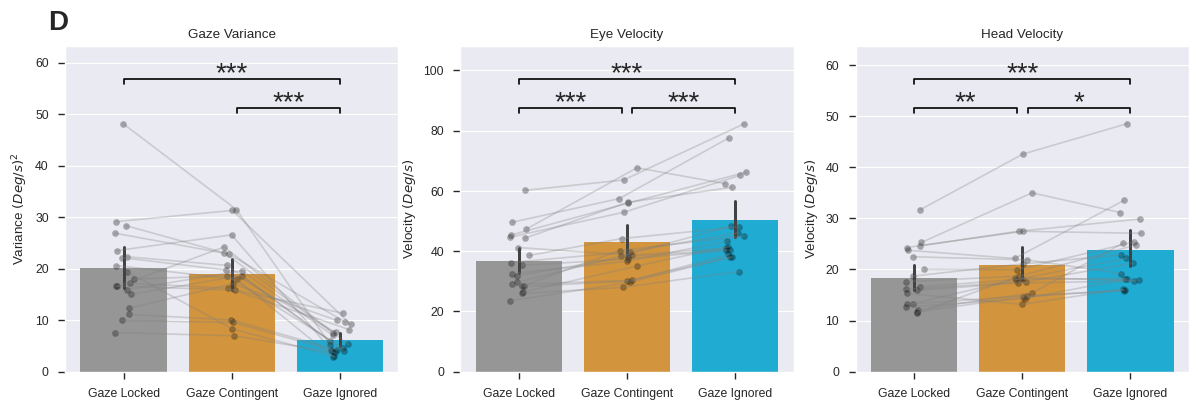

In [22]:
endpoints = ['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 
titles = ['Gaze Variance',  'Eye Velocity', 'Head Velocity']
y_lbls = ['Variance $(Deg/s)^2$', 'Velocity $(Deg/s)$', 'Velocity $(Deg/s)$']

visualization.set_figurestyle()
fig,axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.tight_layout()

for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i], ylabel=y_lbls[i])
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)

plt.savefig('out/gaze_endpoints.png')
visualization.add_panel_index(axs[0], 'D')

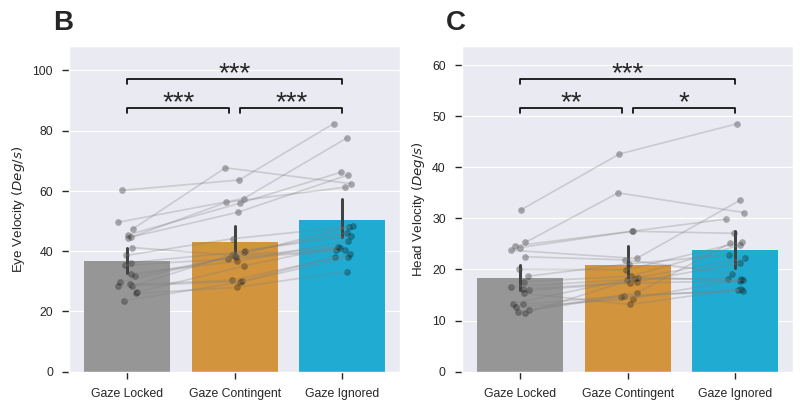

In [51]:
endpoints = ['GazeVarianceEyes', 'AvgVelocityEyes', 'AvgVelocityHead',] # , 'TotalDisplacementEyes', 'TotalDisplacementHead'] 
titles = ['','', ''] # ['Gaze Variance',  'Eye Velocity', 'Head Velocity']
y_lbls = ['Variance $(Deg/s)^2$', 'Eye Velocity $(Deg/s)$', 'Head Velocity $(Deg/s)$']

visualization.set_figurestyle()
fig,axs = visualization.bar_plots(avg, endpoints[1:])
visualization.swarm_plots(avg, endpoints[1:], group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.tight_layout()

for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i+1], ylabel=y_lbls[i+1])
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i+1].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)

plt.savefig('out/gaze_endpoints.png')
visualization.add_panel_index(axs[0], 'B')
visualization.add_panel_index(axs[1], 'C')

### Per subject

In [13]:
# # load data 
# trial_results = pd.read_csv('out/gaze_analysis_trial_endpoints.tsv',sep='\t')
# trial_results = trial_results.set_index(['TrialIdentifier','Subject','GazeCondition'])
# avg = pd.read_csv('out/gaze_analysis_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/gaze_analysis_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/gaze_analysis_paired_testing.tsv', sep='\t').set_index('Comparison')

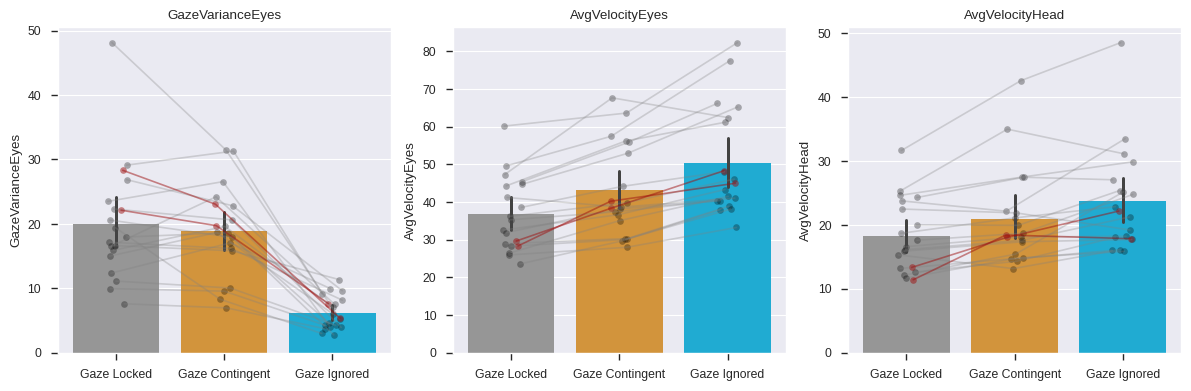

In [15]:
# HIGHLIGHT SPECIFIC SUBJECTS

# S39 Medium gaze variance in all conditions, but relatively large gaze velocity in Gaze Contingent
# S37 Same, but gaze ignored is even more extreme
# Median subjects: S40, S47, S37, S46, S51, S52

mask = avg.Subject.isin(['S37', 'S47'])
highlighted = avg.loc[mask]
standard = avg.loc[~mask]

visualization.set_figurestyle()
fig,axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(standard, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.swarm_plots(highlighted, endpoints, group = 'Subject', axs=axs, fig=fig,
                          linecolor='#9e1111', markercolor='#9e1111', alpha=0.5)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
plt.tight_layout()

(<Figure size 1200x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'EyeTrackerValidity'}, xlabel='Subject', ylabel='EyeTrackerValidity'>,
        <AxesSubplot: title={'center': 'GazeVarianceEyes'}, xlabel='Subject', ylabel='GazeVarianceEyes'>],
       dtype=object))

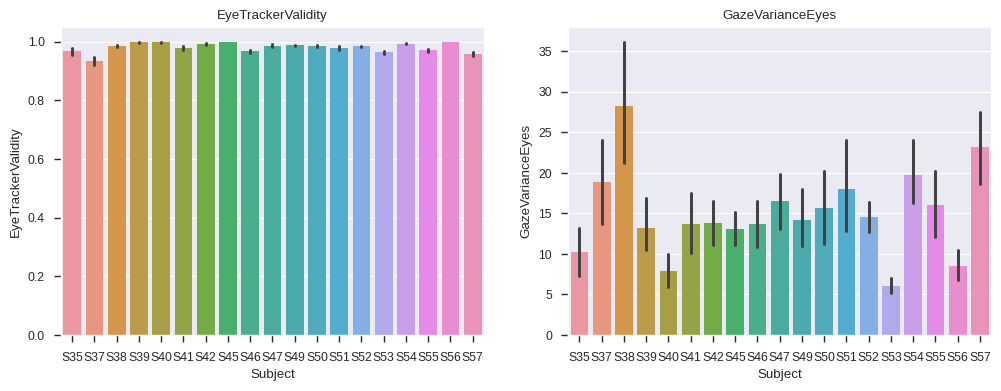

In [16]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
visualization.bar_plots(trial_results.reset_index(),
                        endpoints=['EyeTrackerValidity', 'GazeVarianceEyes'], x='Subject', order=None, fig=fig, axs=axs)

### Gaze Maps

In [18]:
# ### load data 

# # Raw data
# # path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
# path = '../../_Datasets/SPVGazeData/_preprocessed'
# exp_data, calbr_data = data_processing.load_preprocessed_data(path)
# subjects = data_processing.SUBJECTS # or specify subset of subjects
# practice_trials = data_processing.PRACTICE_TRIALS

# eye_data = data_processing.drop_invalid(exp_data['SingleEyeDataRecordC'],
#                                         exclude_trials = practice_trials,
#                                         include_subjects = subjects,
#                                         clip_valid_frames = True,
#                                         check_sensor_validity=True)

# # Processed data
# trial_results = pd.read_csv('out/gaze_analysis_trial_endpoints.tsv',sep='\t')
# trial_results = trial_results.set_index(['TrialIdentifier','Subject','GazeCondition'])
# avg = pd.read_csv('out/gaze_analysis_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/gaze_analysis_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/gaze_analysis_paired_testing.tsv', sep='\t').set_index('Comparison')

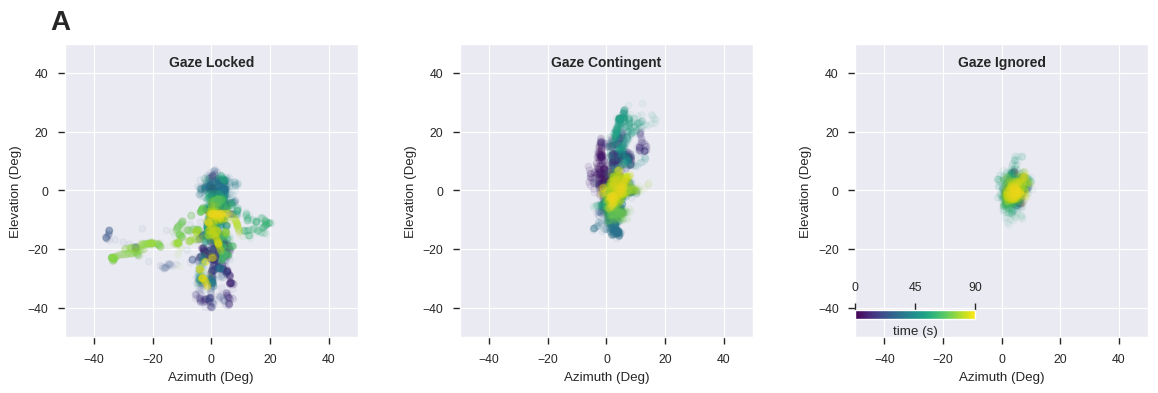

In [56]:
# Plot trials of interest
importlib.reload(visualization)
visualization.set_figurestyle()
trials_of_interest = np.array([ #['S47B4T2', 'S47B5T2', 'S47B6T2',],
                                ['S37B3T3', 'S37B1T3', 'S37B2T3',]])
fig, axs = visualization.plot_gaze_trajectories(eye_data, trials_of_interest, as_line=False, figsize=(4,3.8))

# add colorbar
mappable = matplotlib.cm.ScalarMappable(norm=plt.Normalize(0, 90), cmap='viridis')
# cb_ax = fig.add_axes([.085,.61,.1, .015])
cb_ax = fig.add_axes([.73,.18,.1, .025])
fig.colorbar(mappable,orientation='horizontal',cax=cb_ax, label='time (s)')
cb_ax.xaxis.set_ticks_position('top')
cb_ax.set_xticks([0, 45, 90])

for i,ax in enumerate(axs.flatten()):
    ax.set_title(['Gaze Locked', 'Gaze Contingent', 'Gaze Ignored'][i],y=1.0, pad=-16, fontweight='bold', fontsize=10)

visualization.add_panel_index(axs[0],'A')

# # Save Figure
# fig.savefig('out/gaze_maps.png')

# Other data checks

###  Variance and validity <> performance? 

In [ ]:
# ### load data 

# # Raw data
# # path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_10'
# path = '../../_Datasets/SPVGazeData/_preprocessed'
# exp_data, calbr_data = data_processing.load_preprocessed_data(path)
# subjects = data_processing.SUBJECTS # or specify subset of subjects
# practice_trials = data_processing.PRACTICE_TRIALS

# eye_data = data_processing.drop_invalid(exp_data['SingleEyeDataRecordC'],
#                                         exclude_trials = practice_trials,
#                                         include_subjects = subjects,
#                                         clip_valid_frames = True,
#                                         check_sensor_validity=True)

# # Processed data
# gaze_results = pd.read_csv('out/gaze_analysis_trial_endpoints.tsv',sep='\t')

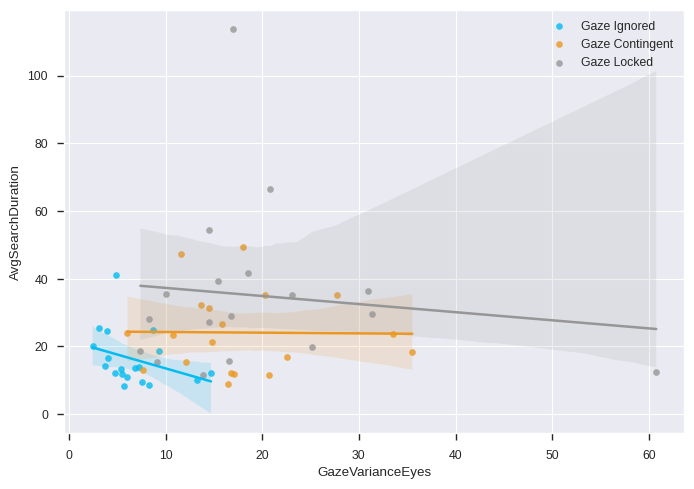

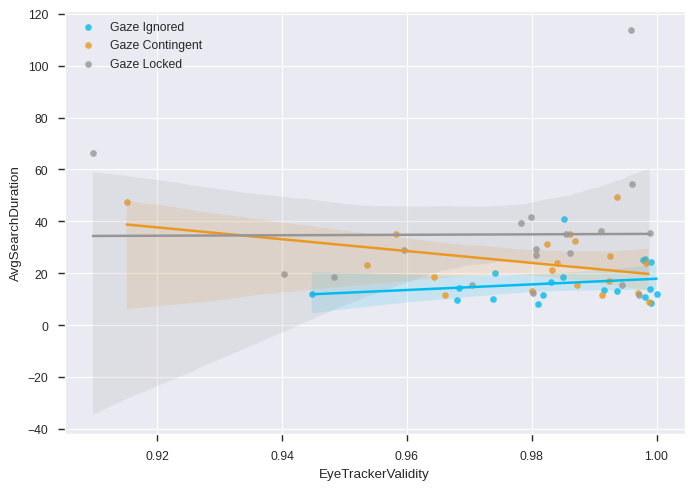

In [21]:
endpoints = ['EyeTrackerValidity', 'GazeVarianceEyes', 'AvgVelocityEyes', 
             'TotalDisplacementEyes', 'GazeVarianceHead', 'AvgVelocityHead',
             'TotalFoundTargets', 'AvgSearchDuration']

## Combine gaze results with visual search results

# load gaze results
gaze_results = pd.read_csv('out/gaze_analysis_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')
vs_results = gaze_results.loc[gaze_results.ExperimentalTask=='VisualSearch'].copy()

# Add visual search results
localization_errors = pd.read_csv('../visual_search/out/all_localization_errors.tsv', sep='\t')
grouped_by_trial = localization_errors.groupby('TrialIdentifier')

total_found_targets = grouped_by_trial.FoundCorrectTarget.sum()
average_search_duration = grouped_by_trial.SearchDuration.mean()
vs_results.loc[total_found_targets.index, 'TotalFoundTargets'] = total_found_targets
vs_results.loc[average_search_duration.index, 'AvgSearchDuration'] = average_search_duration

avg = stats.average(vs_results.reset_index(), y=endpoints, group='Subject', x='GazeCondition')

invalid_subjects = avg.Subject.isin(['S38', 'S51', 'S52', 'S57'])

for condition, lbl in visualization.COND_REDEFINED.items():
    sns.regplot(data=avg.loc[(avg.GazeCondition==condition)], x='GazeVarianceEyes', y='AvgSearchDuration', label=lbl)
plt.legend()
plt.show()

for condition, lbl in visualization.COND_REDEFINED.items():
    sns.regplot(data=avg.loc[(avg.GazeCondition==condition)], x='EyeTrackerValidity', y='AvgSearchDuration', label=lbl)
plt.legend()
plt.show()

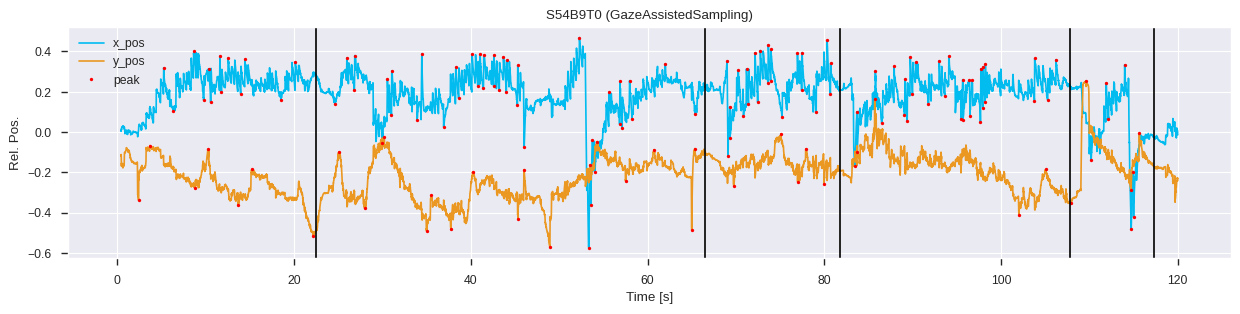

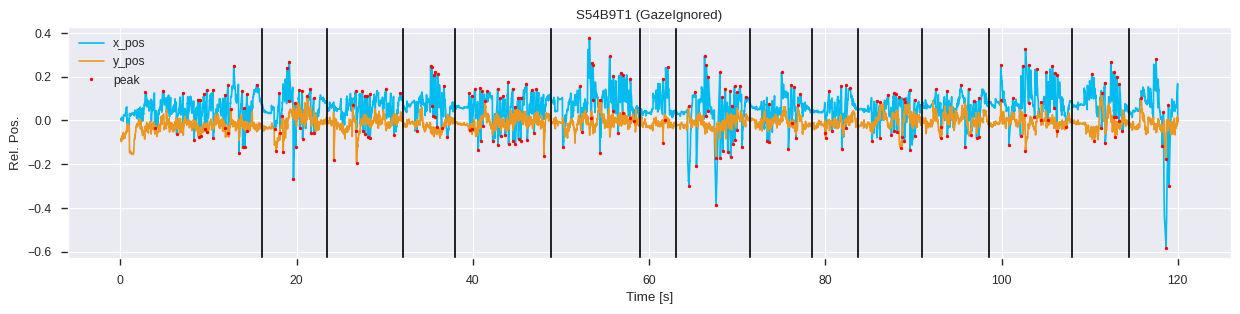

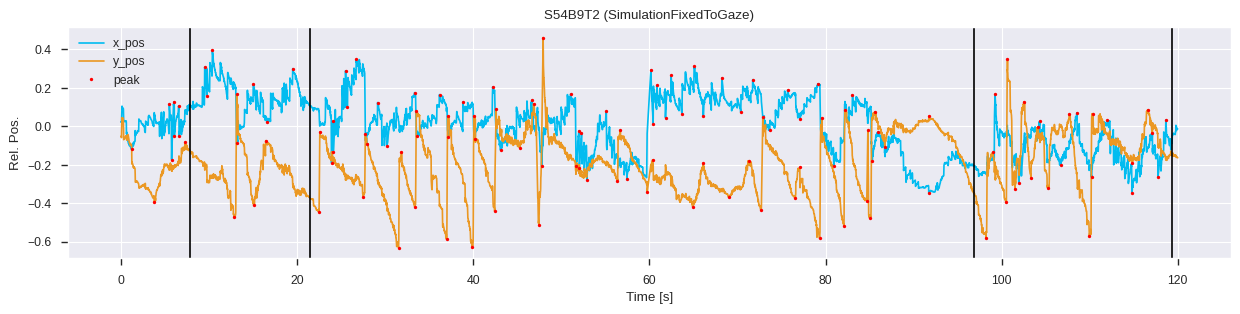

In [24]:
import scipy
def plot_time_series(trial_identifier, remove_missing=False, peak_prominence=0.15):
    eye_data = exp_data['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = exp_data['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  exp_data['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY
    
    # Plot x and y position of the eye
    ax.plot(t, pos_x, label = 'x_pos')
    ax.plot(t, pos_y, label = 'y_pos')
    
    # Find peaks 
    x_peaks = scipy.signal.find_peaks(pos_x, prominence=peak_prominence)[0].tolist() # local maxima
    x_peaks += scipy.signal.find_peaks(-pos_x, prominence=peak_prominence)[0].tolist() #local minima
    y_peaks = scipy.signal.find_peaks(pos_y, prominence=peak_prominence)[0].tolist()
    y_peaks += scipy.signal.find_peaks(-pos_y, prominence=peak_prominence)[0].tolist()

    ax.plot(t.iloc[x_peaks], pos_x.iloc[x_peaks], 'r.', label = 'peak')
    ax.plot(t.iloc[y_peaks], pos_y.iloc[y_peaks], 'r.' )

        
    # Plot reported events as vertical lines    
    events = engine_data.ReportedEventsCount.diff() > 0
    for t in engine_data.loc[events].TimeElapsed:        
        ax.axvline(t, color='k')
        
    ax.legend() 
    ax.set(title=f'{trial_identifier} ({trial_data.GazeCondition})',
           xlabel = 'Time [s]',
           ylabel = 'Rel. Pos.')  

    return fig, ax
    
_, ax0 = plot_time_series('S54B9T0', remove_missing=True)
_, ax1 = plot_time_series('S54B9T1', remove_missing=True)
_, ax2 = plot_time_series('S54B9T2', remove_missing=True)

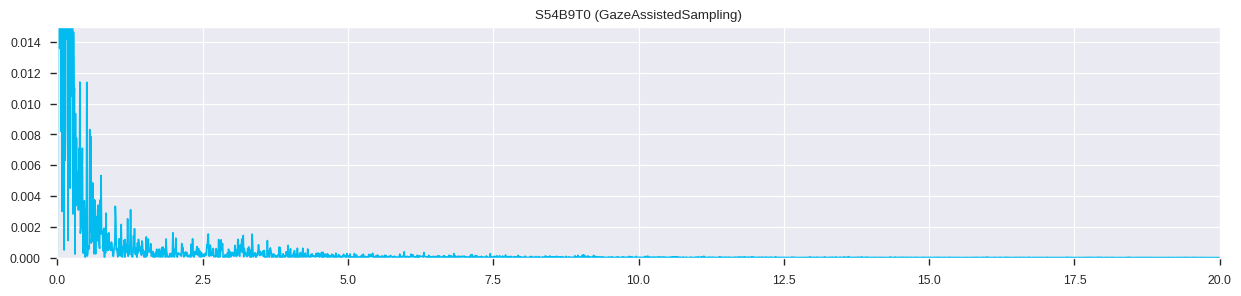

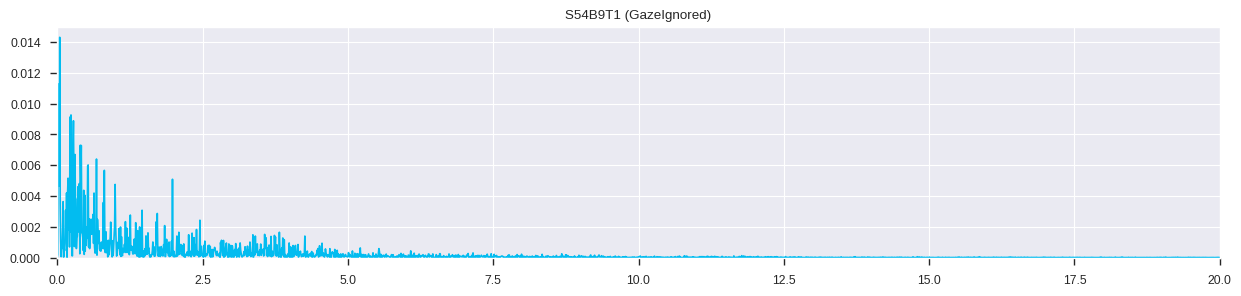

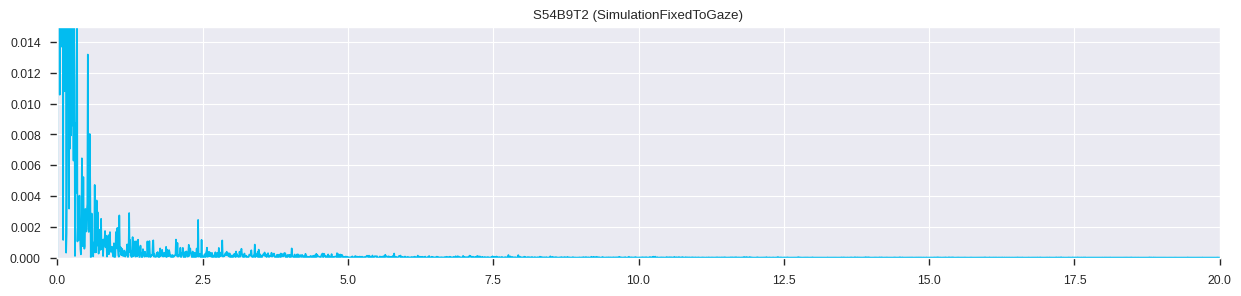

In [25]:
def plot_periodogram(trial_identifier, remove_missing=False, fs=65):
    eye_data = exp_data['SingleEyeDataRecordC'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()
    trial_data = exp_data['TrialConfigRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy()
    engine_data =  exp_data['EngineDataRecord'].set_index('TrialIdentifier').loc[trial_identifier].copy().reset_index()

    
    fig, ax = plt.subplots(figsize=(15,3),dpi=100)
    
     # Calculate elapsed time for each trial
    for data in [eye_data, engine_data]:
        start_of_trial = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
        t_0 = data.where(start_of_trial).TimeStamp.ffill()
        data['TimeElapsed'] = (data.TimeStamp - t_0) * 1e-7
    
    # Remove missing data
    eye_data['Missing'] = eye_data.GazeDirectionNormInEyeX == -1
    if remove_missing:
        eye_data = eye_data.loc[~eye_data.Missing]
    
    # Ignore data after trial finish
    eye_data = eye_data.loc[eye_data.TimeElapsed <= trial_data.TrialDuration]
    
    # Extract time series
    t = eye_data.TimeElapsed
    pos_x = eye_data.GazeDirectionNormInEyeX
    pos_y = eye_data.GazeDirectionNormInEyeY

#     speed = np.sqrt(pos_x**2 + pos_y**2) / t
    
    
    f, Pxx_den = scipy.signal.periodogram(pos_x,fs)
    ax.plot(f, Pxx_den)
            
#     ax.legend() 
    ax.set(title = f'{trial_identifier} ({trial_data.GazeCondition})',
          ylim = [0,0.015],
          xlim = [0,20])
           
    ax.set()

    return fig, ax
    
_, ax0 = plot_periodogram('S54B9T0', remove_missing=True)
_, ax1 = plot_periodogram('S54B9T1', remove_missing=True)
_, ax2 = plot_periodogram('S54B9T2', remove_missing=True)

## More Gaze Maps

(<Figure size 1200x2400 with 18 Axes>,
 array([[<AxesSubplot: title={'center': 'S47B1T1 (19.91 s) \nGaze Locked'}>,
         <AxesSubplot: title={'center': 'S47B2T1 (15.86 s) \nGaze Ignored'}>,
         <AxesSubplot: title={'center': 'S47B3T1 (65.36 s) \nGaze Contingent'}>],
        [<AxesSubplot: title={'center': 'S47B1T2 (63.62 s) \nGaze Locked'}>,
         <AxesSubplot: title={'center': 'S47B2T2 (27.19 s) \nGaze Ignored'}>,
         <AxesSubplot: title={'center': 'S47B3T2 (43.11 s) \nGaze Contingent'}>],
        [<AxesSubplot: title={'center': 'S47B1T3 (58.35 s) \nGaze Locked'}>,
         <AxesSubplot: title={'center': 'S47B2T3 (40.39 s) \nGaze Ignored'}>,
         <AxesSubplot: title={'center': 'S47B3T3 (37.56 s) \nGaze Contingent'}>],
        [<AxesSubplot: title={'center': 'S47B4T1 (64.15 s) \nGaze Locked'}>,
         <AxesSubplot: title={'center': 'S47B5T1 (31.85 s) \nGaze Contingent'}>,
         <AxesSubplot: title={'center': 'S47B6T1 (10.09 s) \nGaze Ignored'}>],
        [<Axe

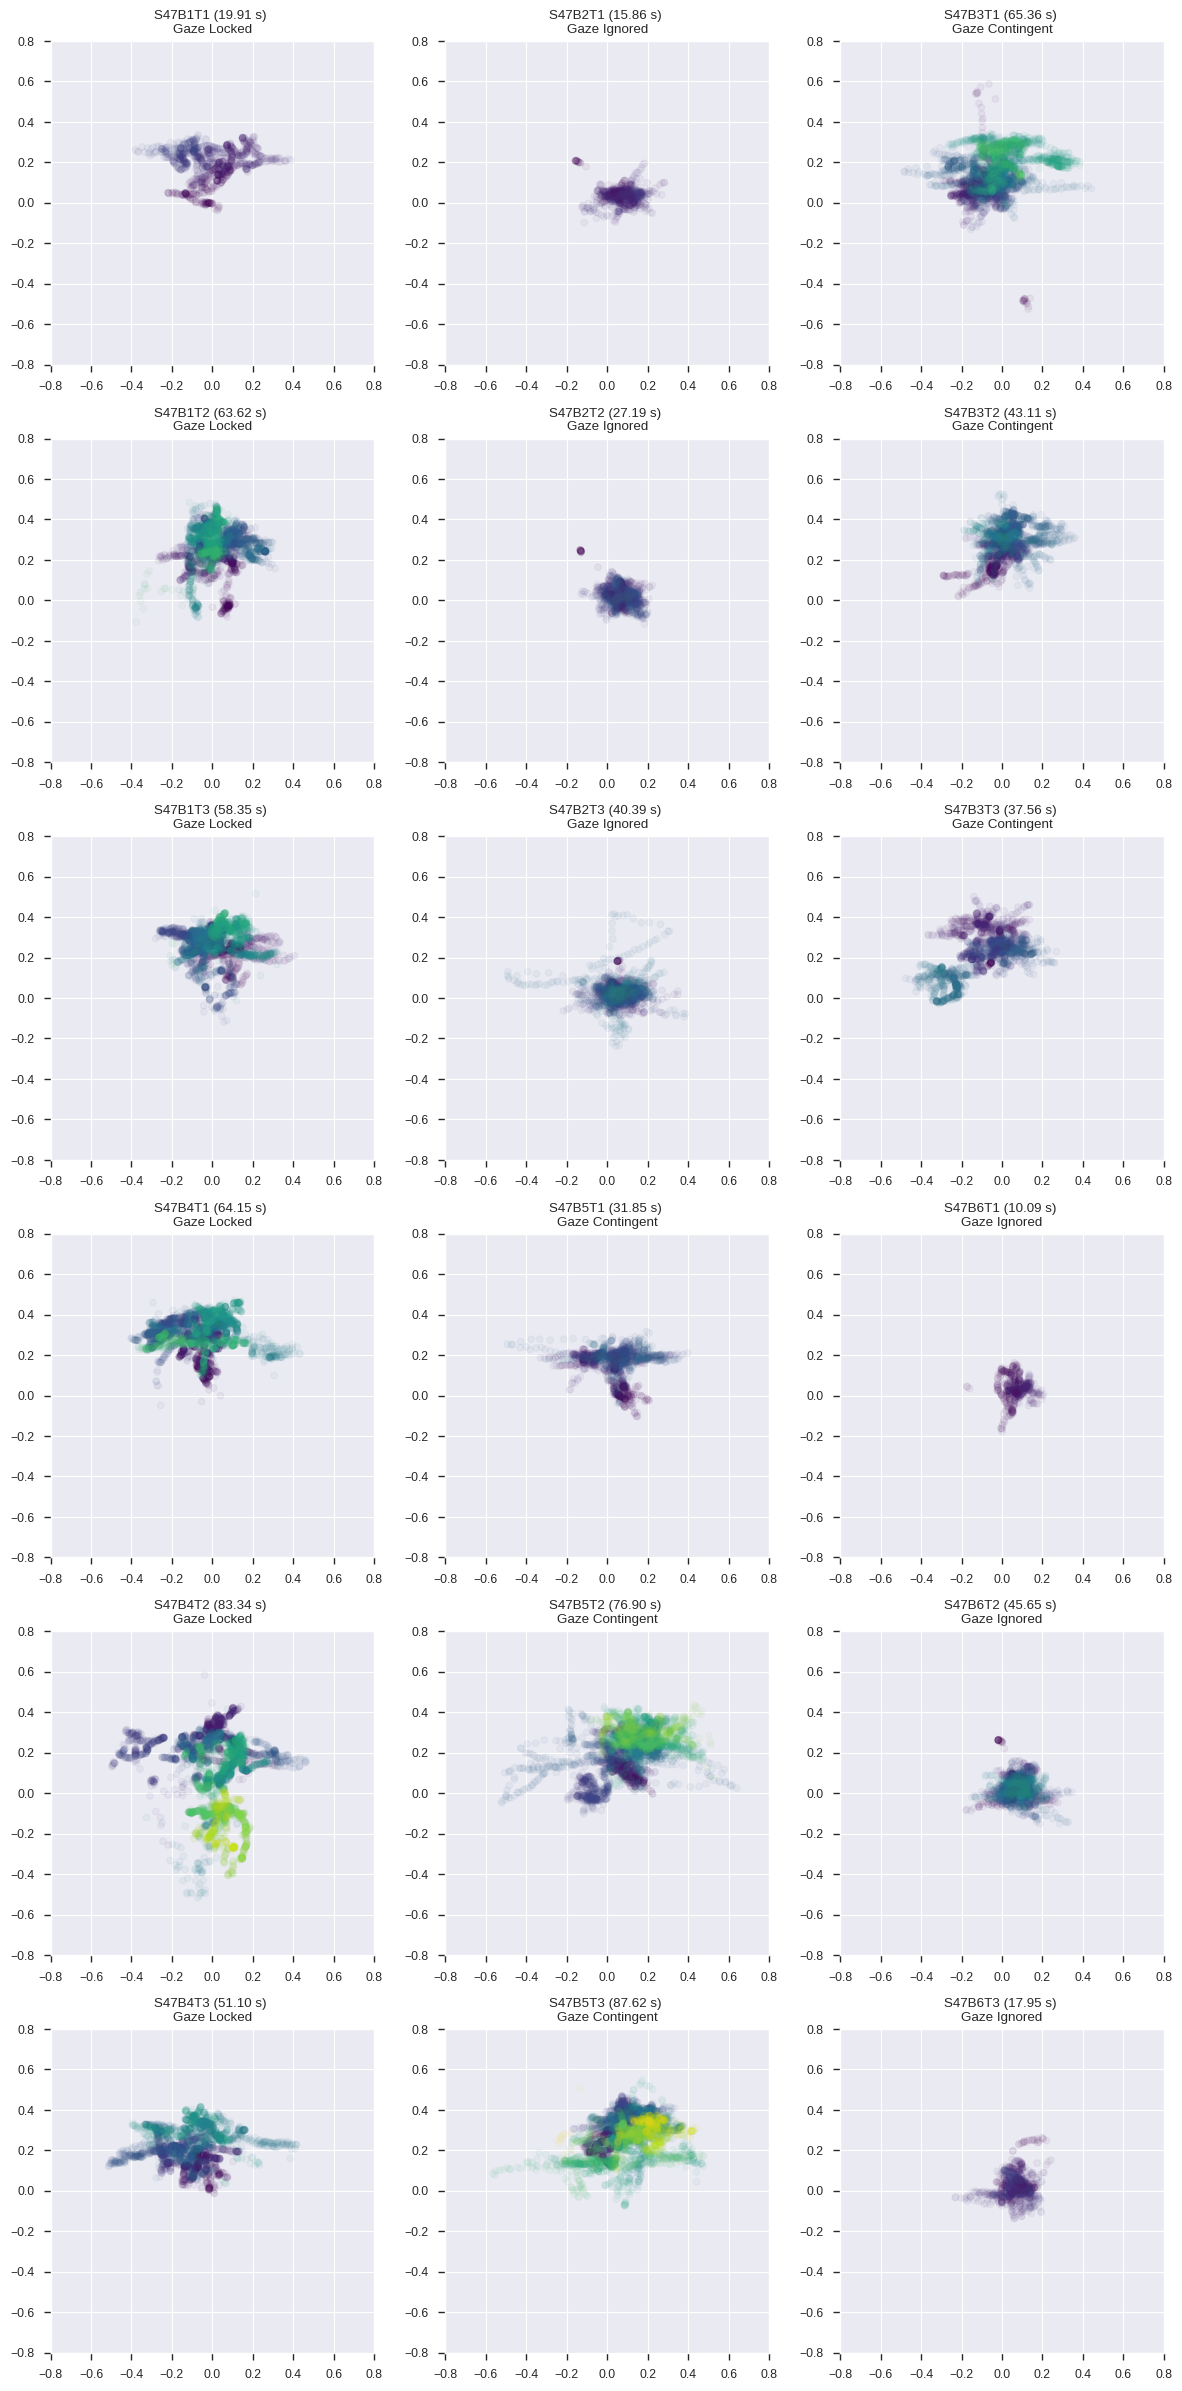

In [376]:
trials_of_interest = np.array([['S47B1T1', 'S47B2T1', 'S47B3T1'], 
                               ['S47B1T2', 'S47B2T2', 'S47B3T2'],
                               ['S47B1T3', 'S47B2T3', 'S47B3T3'],                               
                               ['S47B4T1', 'S47B5T1', 'S47B6T1'],
                               ['S47B4T2', 'S47B5T2', 'S47B6T2'],
                               ['S47B4T3', 'S47B5T3', 'S47B6T3'],])
plot_gaze_maps(trials_of_interest)

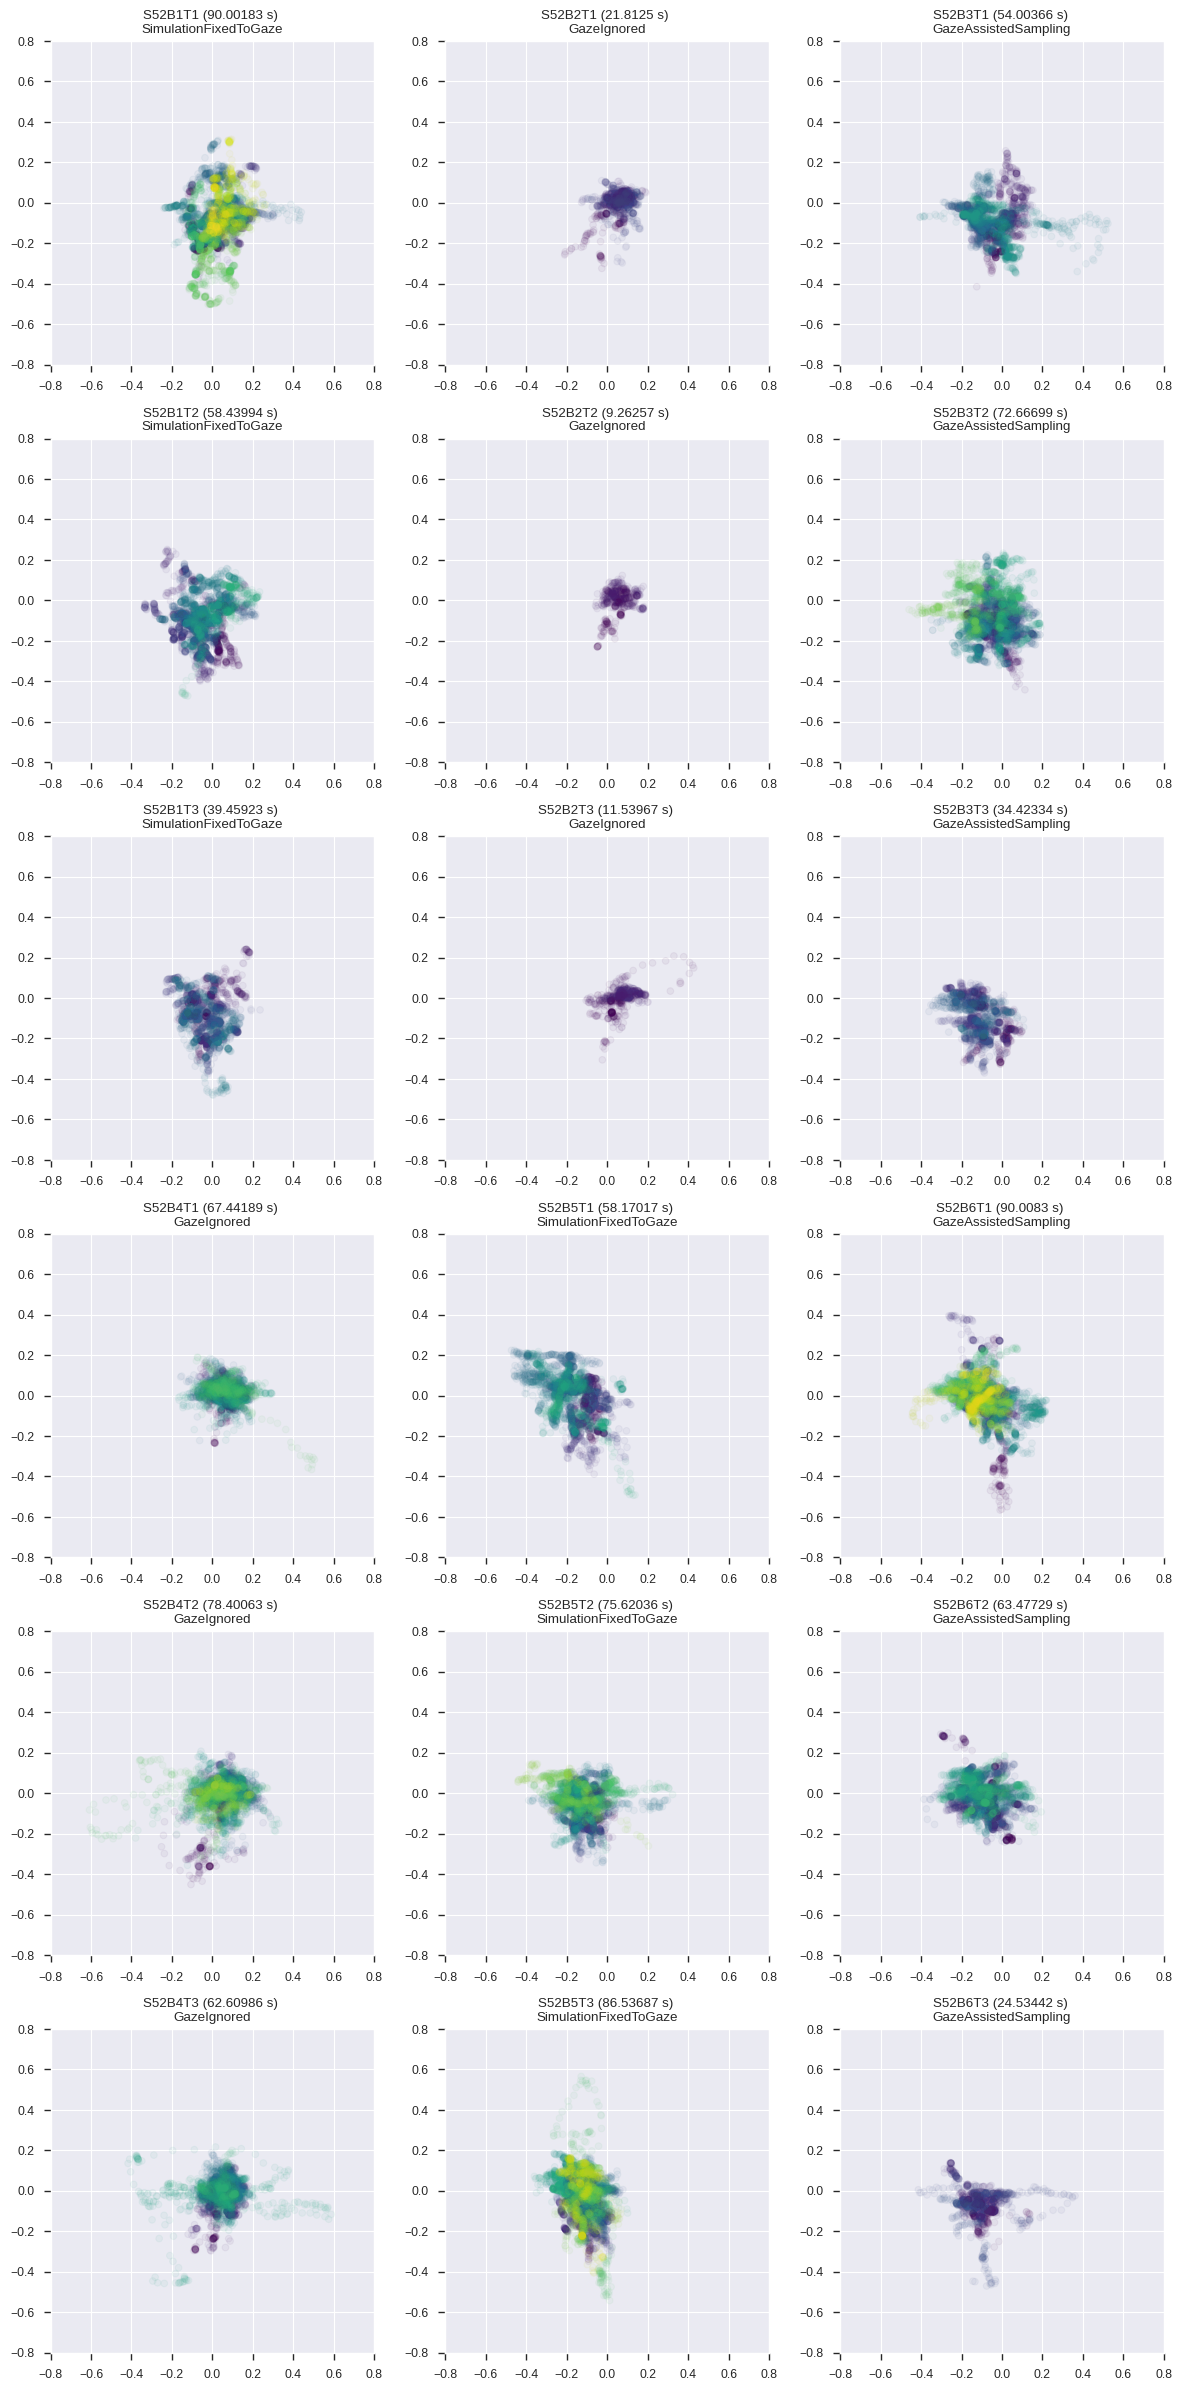

In [246]:
trials_of_interest = np.array([['S52B1T1', 'S52B2T1', 'S52B3T1'], 
                               ['S52B1T2', 'S52B2T2', 'S52B3T2'],
                               ['S52B1T3', 'S52B2T3', 'S52B3T3'],                               
                               ['S52B4T1', 'S52B5T1', 'S52B6T1'],
                               ['S52B4T2', 'S52B5T2', 'S52B6T2'],
                               ['S52B4T3', 'S52B5T3', 'S52B6T3'],])
plot_gaze_maps(trials_of_interest)

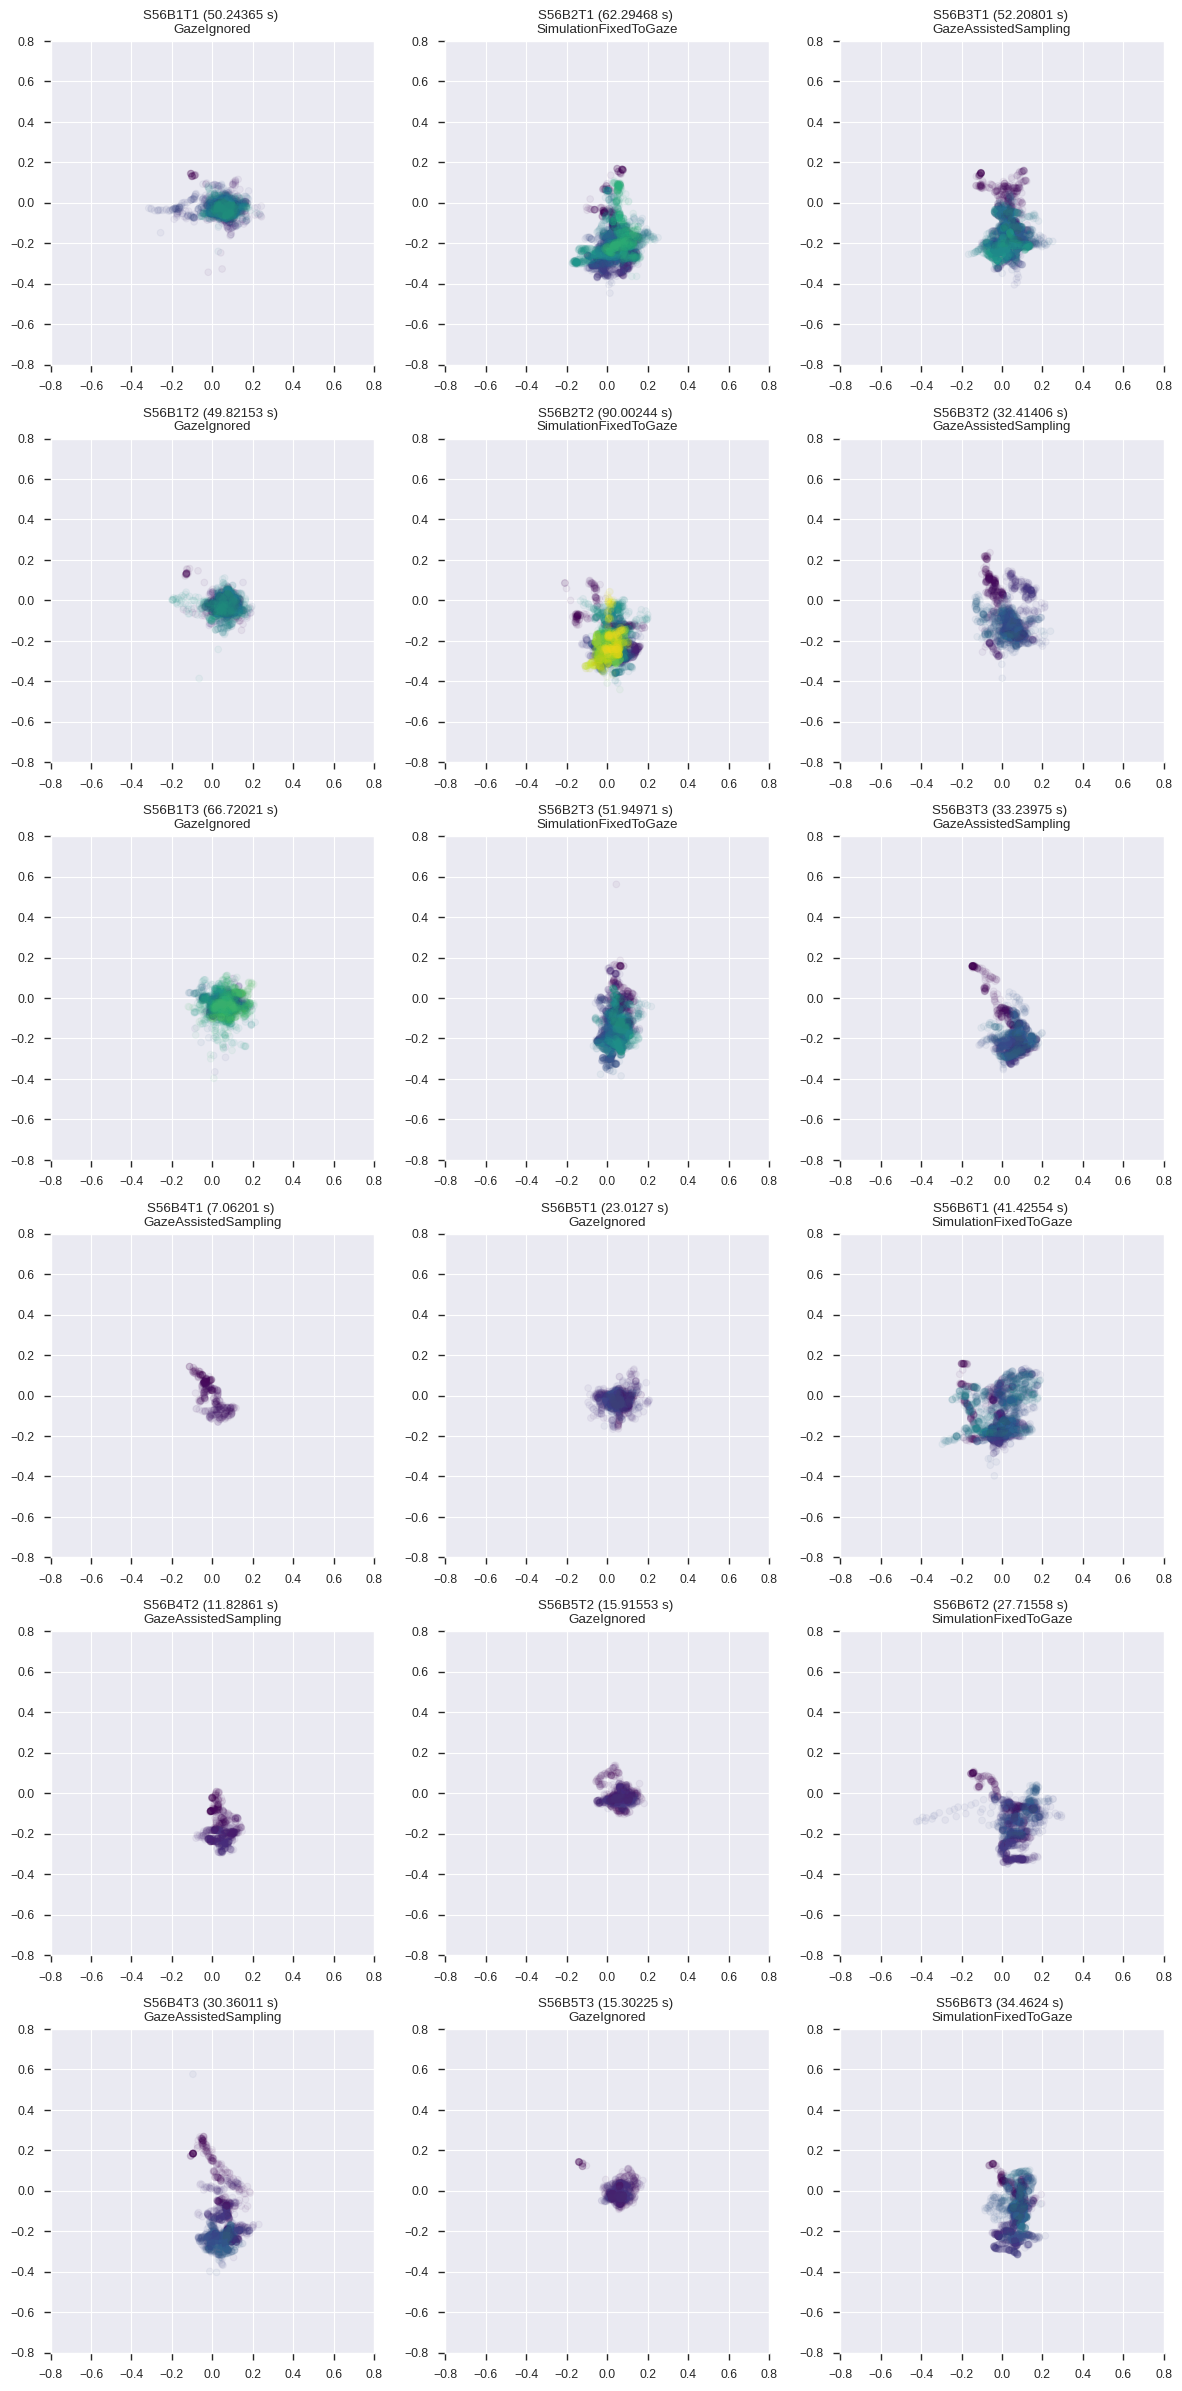

In [209]:
trials_of_interest = np.array([['S56B1T1', 'S56B2T1', 'S56B3T1'], 
                               ['S56B1T2', 'S56B2T2', 'S56B3T2'],
                               ['S56B1T3', 'S56B2T3', 'S56B3T3'],                               
                               ['S56B4T1', 'S56B5T1', 'S56B6T1'],
                               ['S56B4T2', 'S56B5T2', 'S56B6T2'],
                               ['S56B4T3', 'S56B5T3', 'S56B6T3'],])
plot_gaze_maps(trials_of_interest)

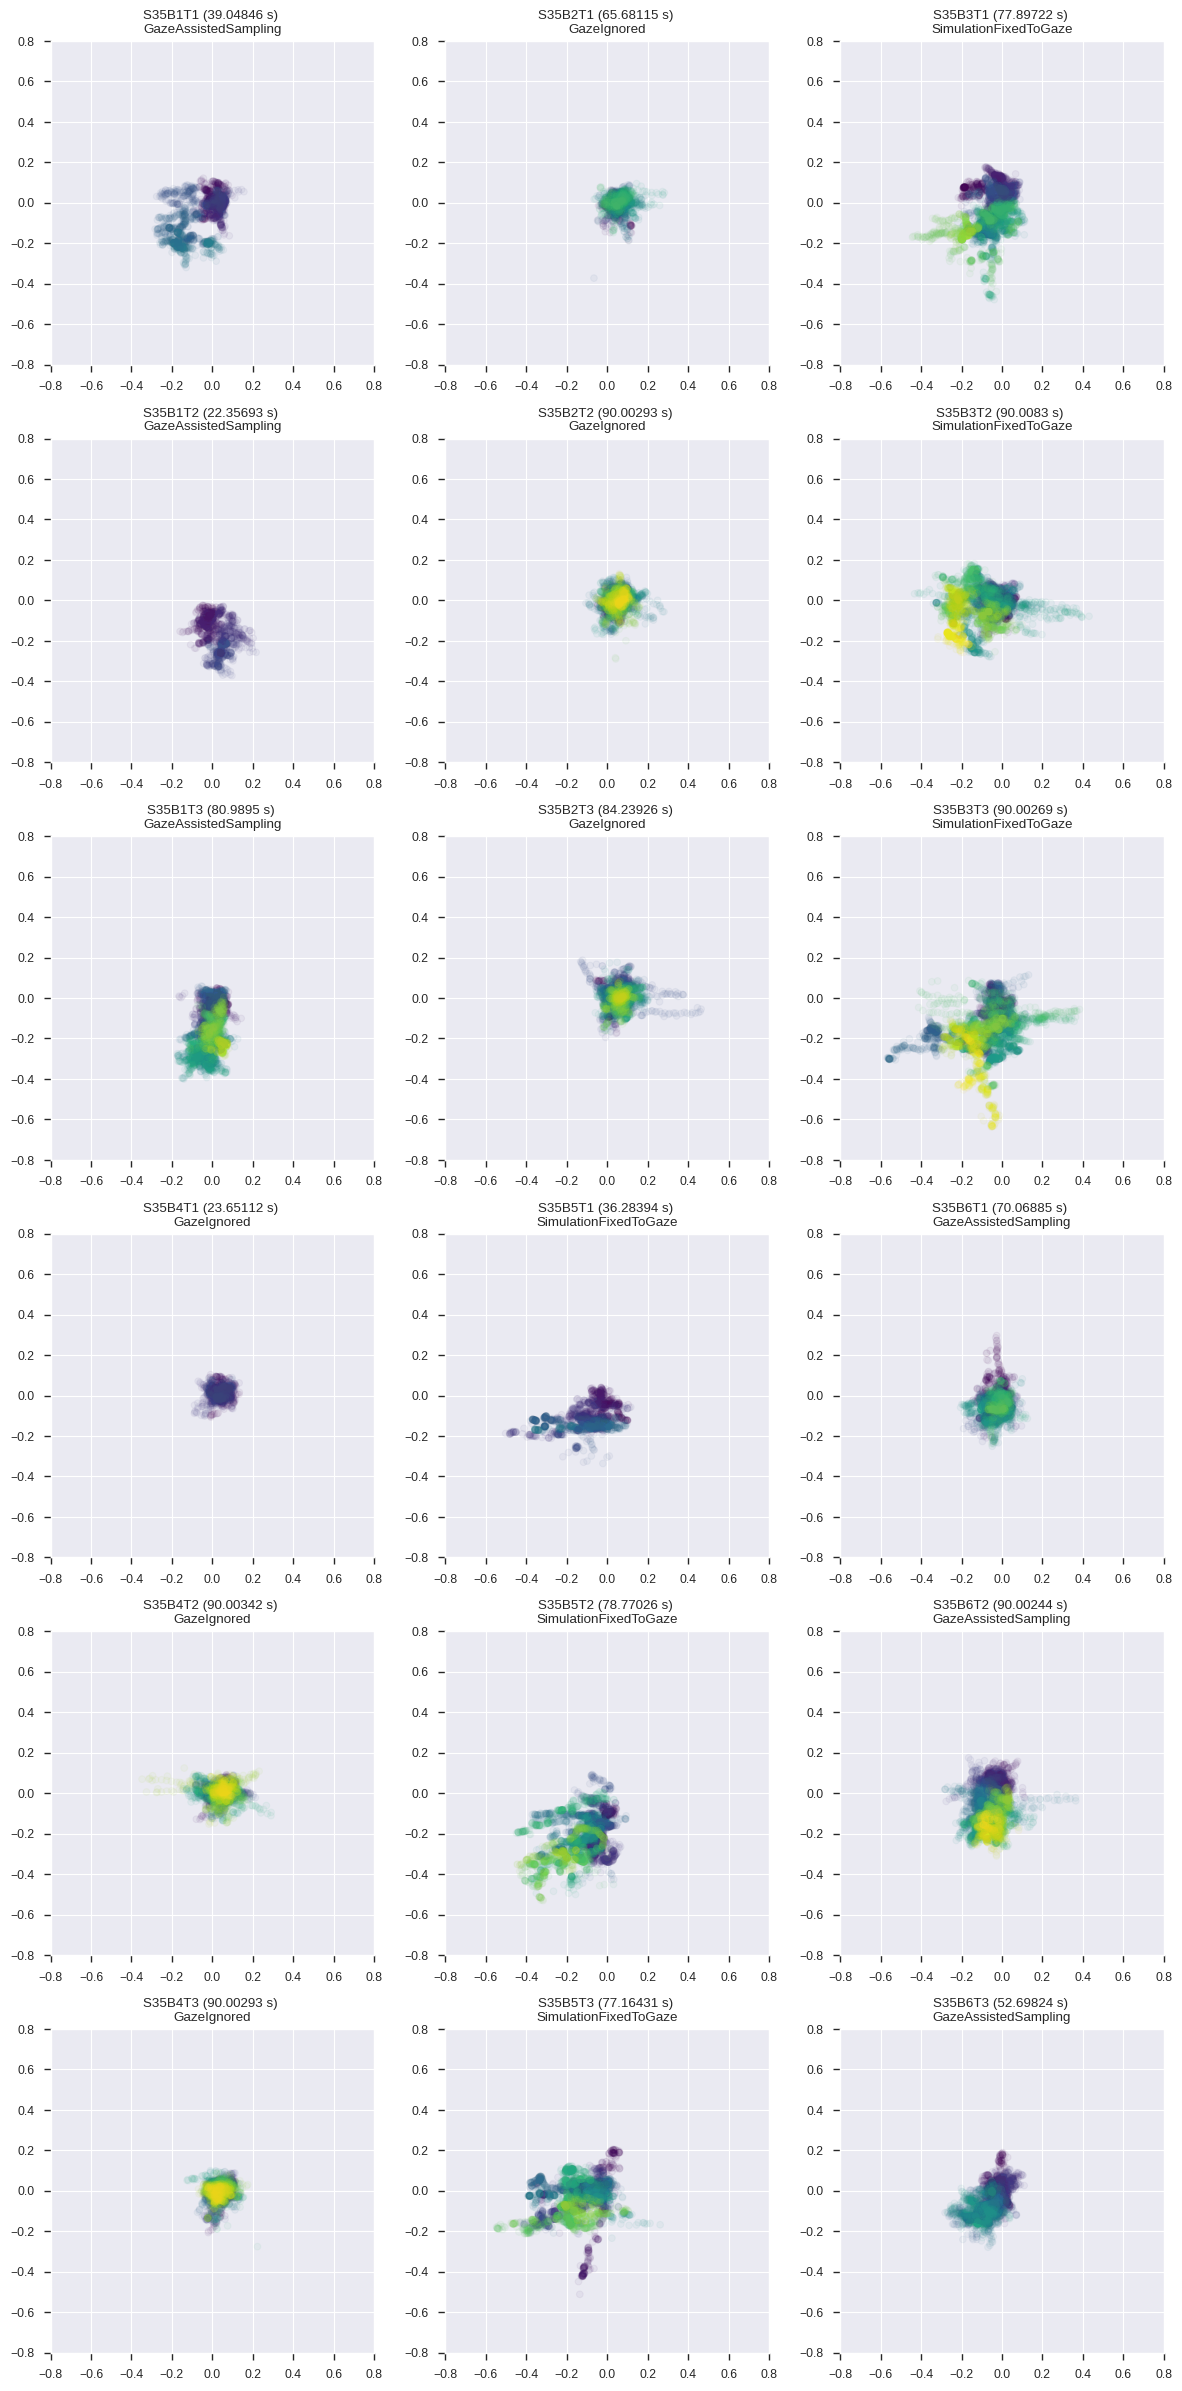

In [115]:
trials_of_interest = np.array([['S35B1T1', 'S35B2T1', 'S35B3T1'], 
                               ['S35B1T2', 'S35B2T2', 'S35B3T2'],
                               ['S35B1T3', 'S35B2T3', 'S35B3T3'],                               
                               ['S35B4T1', 'S35B5T1', 'S35B6T1'],
                               ['S35B4T2', 'S35B5T2', 'S35B6T2'],
                               ['S35B4T3', 'S35B5T3', 'S35B6T3'],])
plot_gaze_maps(trials_of_interest)
    


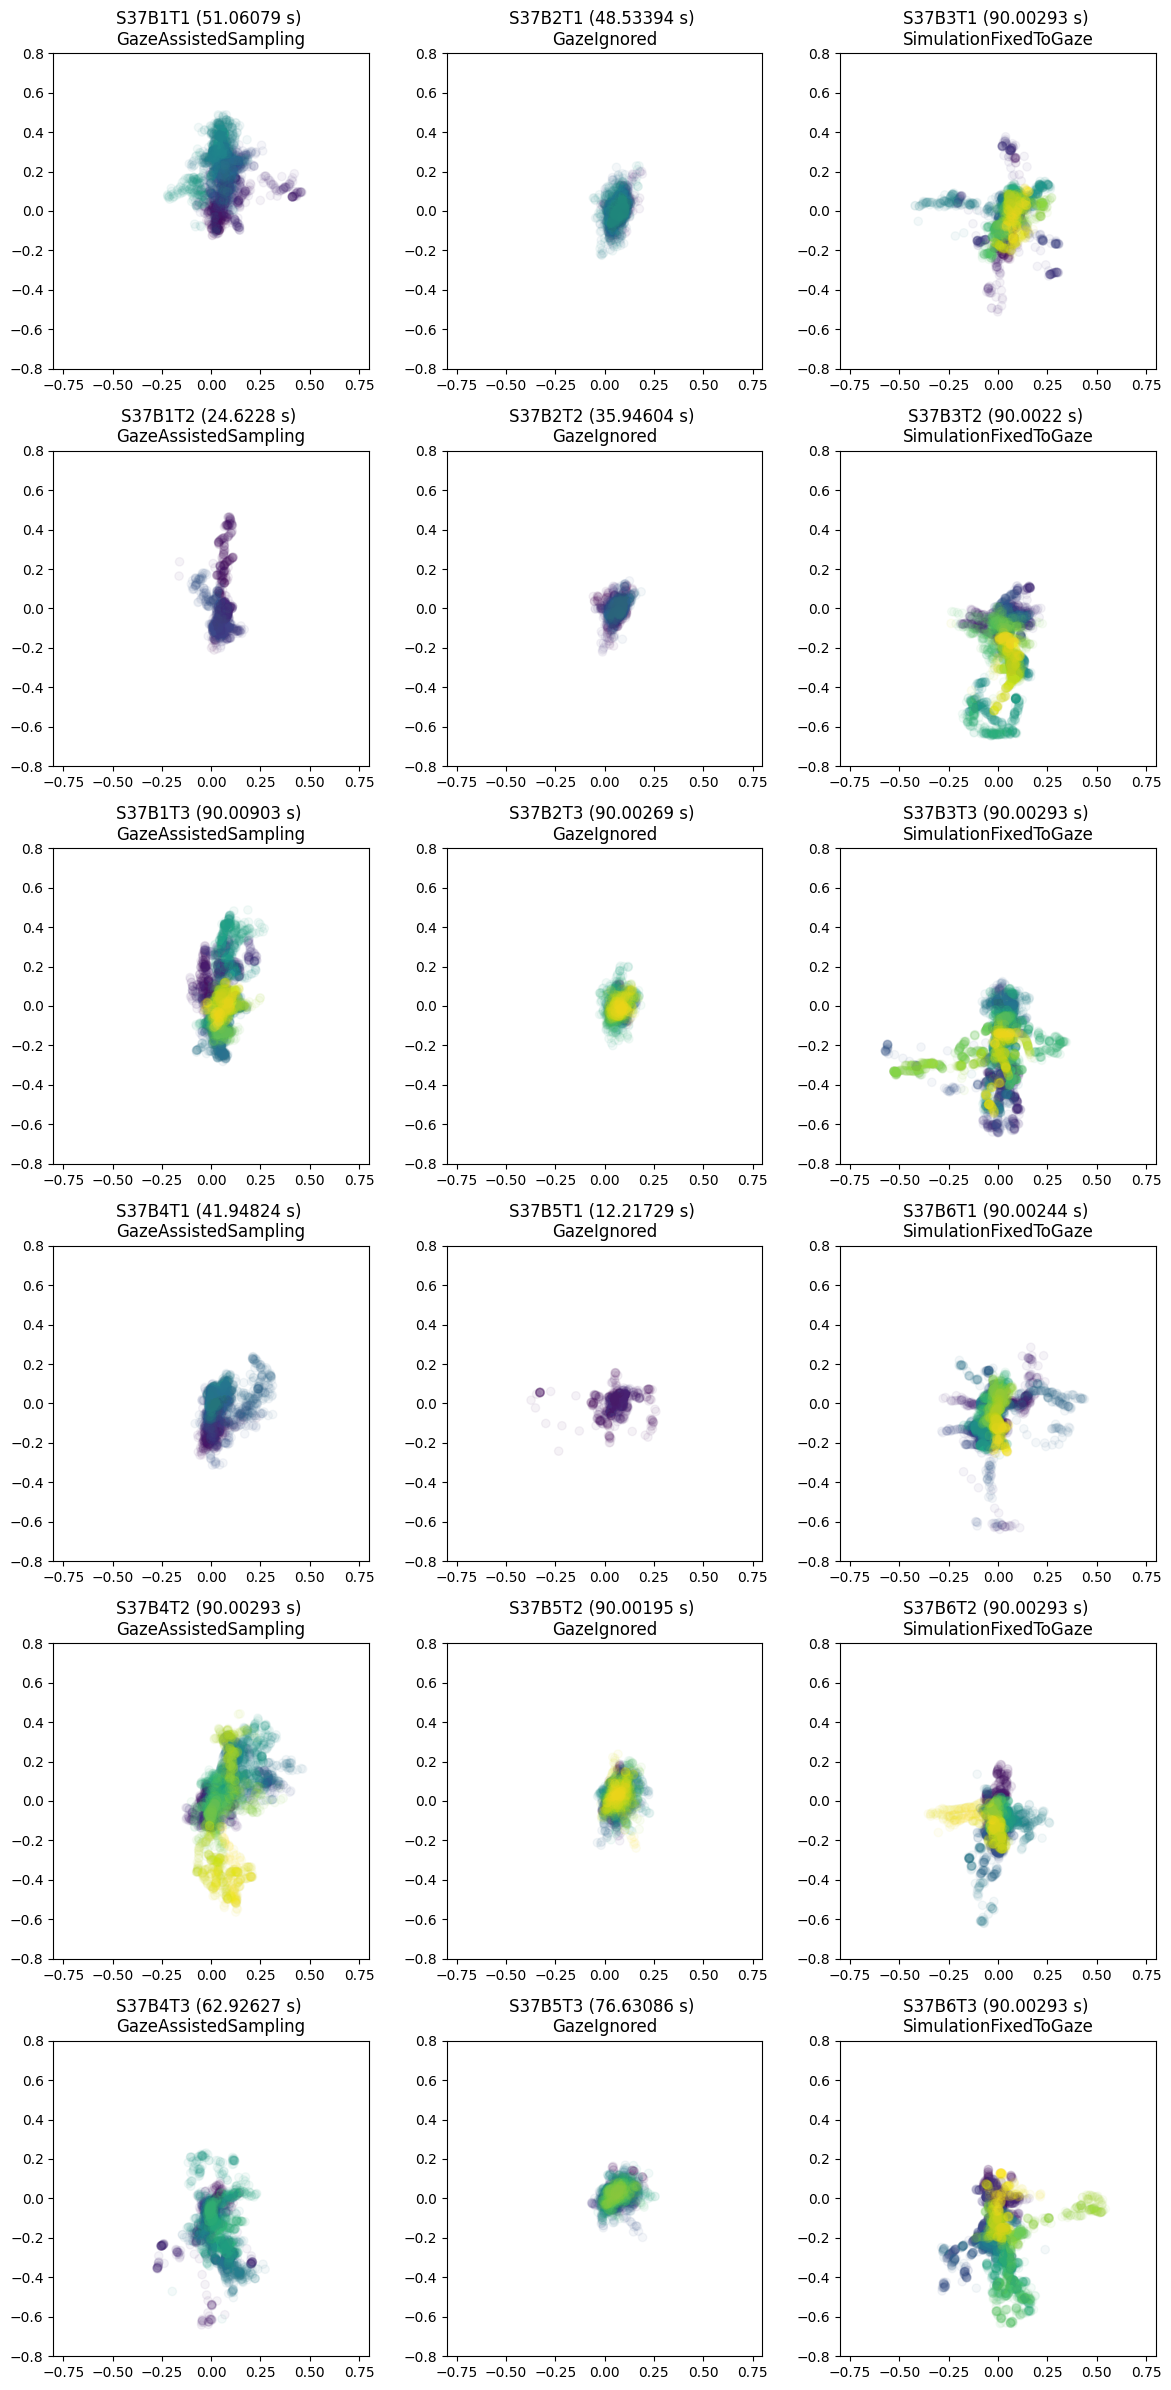

In [70]:
trials_of_interest = np.array([['S37B1T1', 'S37B2T1', 'S37B3T1'], 
                               ['S37B1T2', 'S37B2T2', 'S37B3T2'],
                               ['S37B1T3', 'S37B2T3', 'S37B3T3'],                               
                               ['S37B4T1', 'S37B5T1', 'S37B6T1'],
                               ['S37B4T2', 'S37B5T2', 'S37B6T2'],
                               ['S37B4T3', 'S37B5T3', 'S37B6T3'],])
plot_gaze_maps(trials_of_interest)
    


In [58]:
tr = exp_data['TrialConfigRecord']
tr.loc[tr.Subject ==s]
tr.Subject.iloc[-1]

'S57'

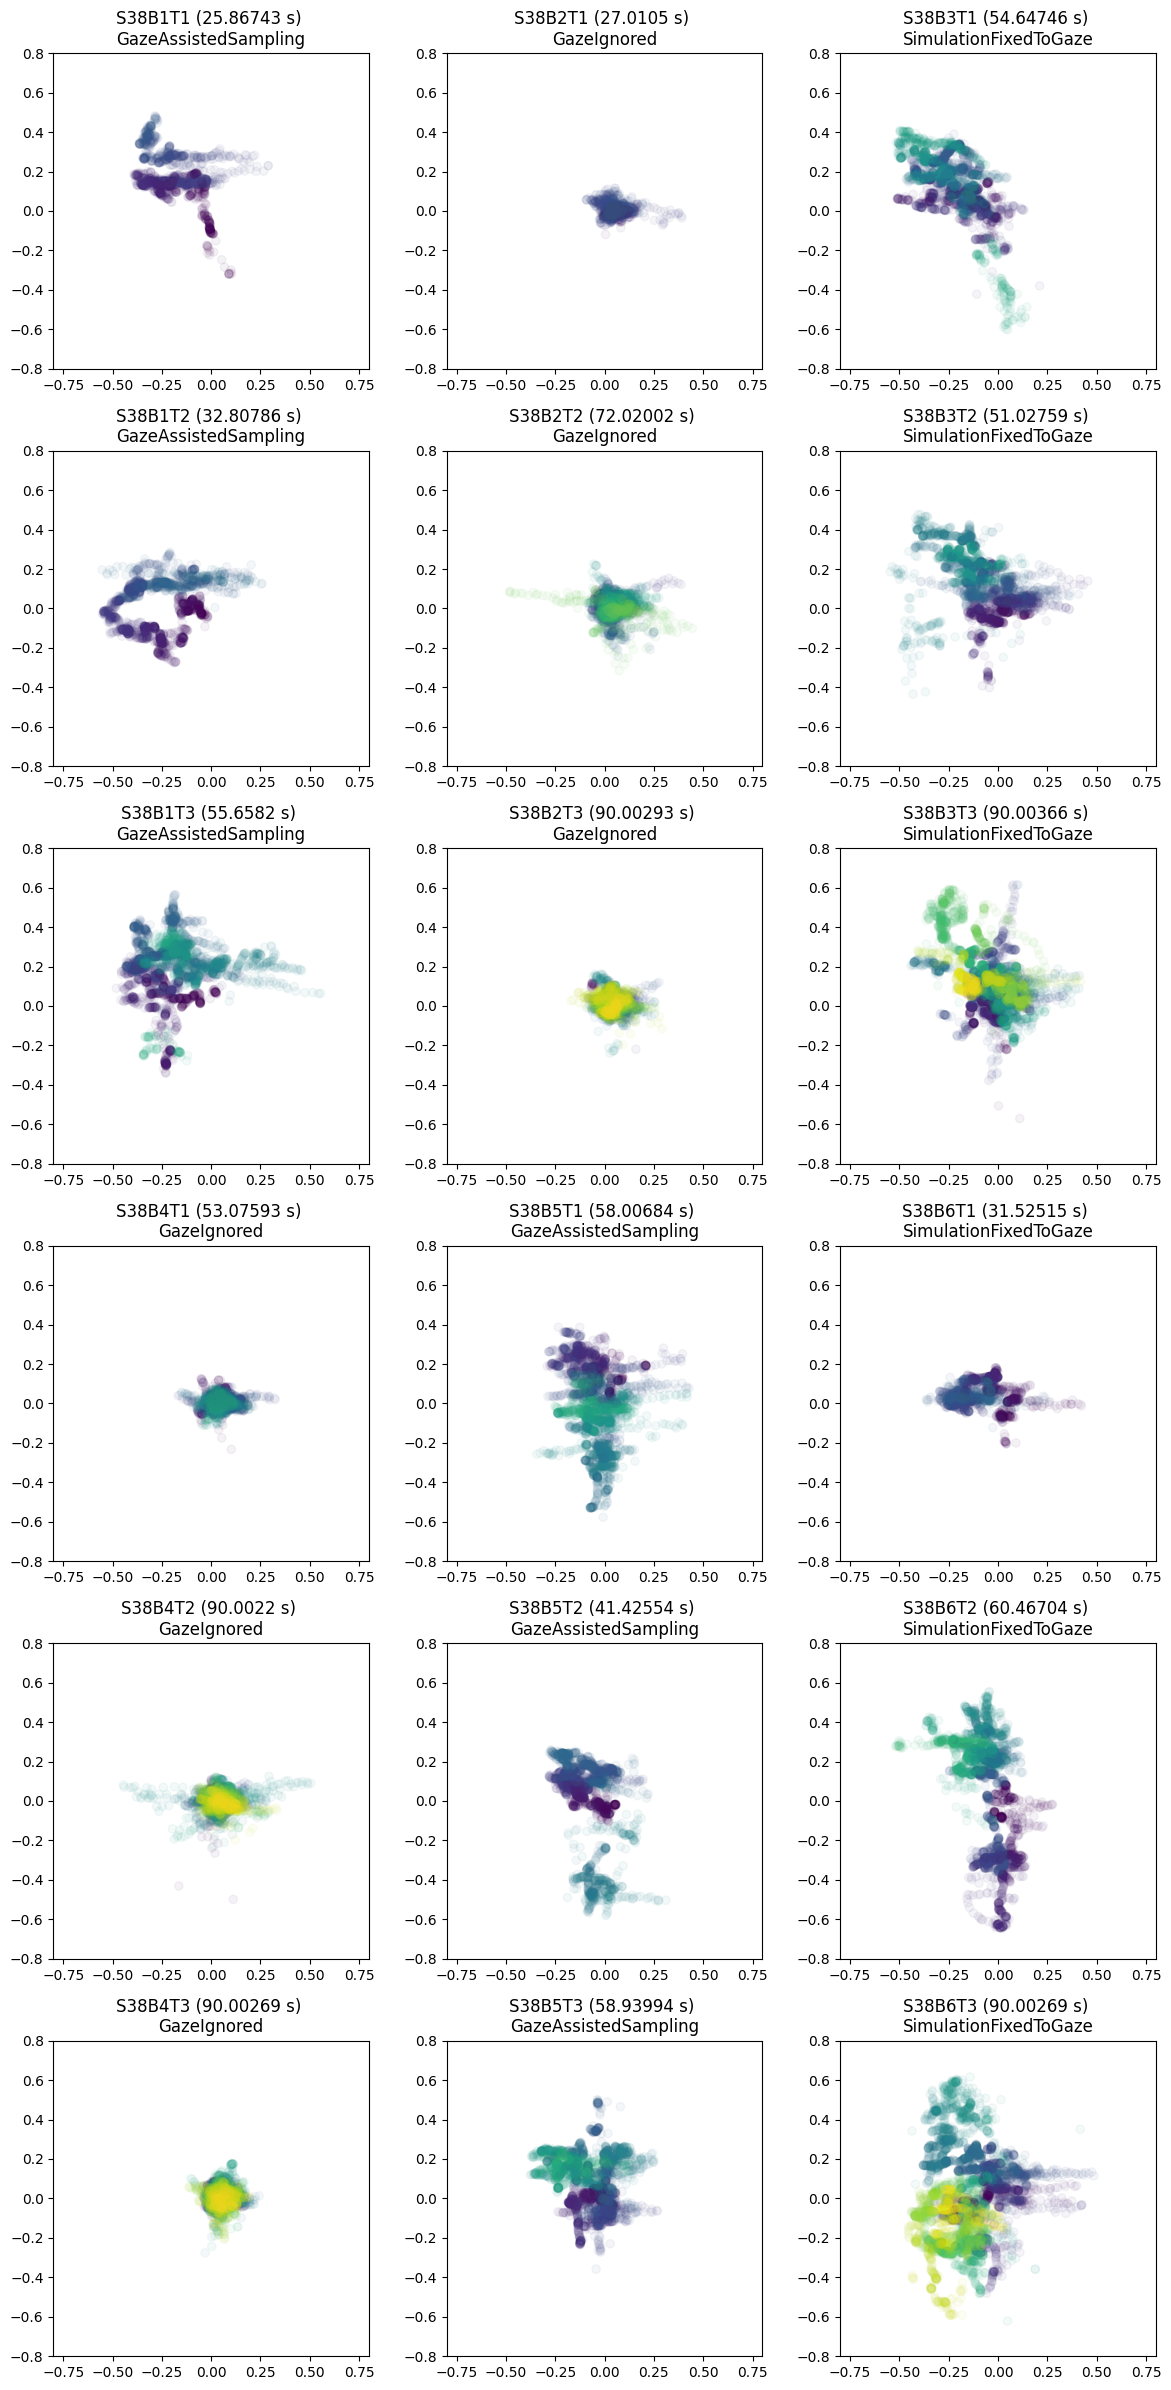

In [71]:
trials_of_interest = np.array([['S38B1T1', 'S38B2T1', 'S38B3T1'], 
                               ['S38B1T2', 'S38B2T2', 'S38B3T2'],
                               ['S38B1T3', 'S38B2T3', 'S38B3T3'],                               
                               ['S38B4T1', 'S38B5T1', 'S38B6T1'],
                               ['S38B4T2', 'S38B5T2', 'S38B6T2'],
                               ['S38B4T3', 'S38B5T3', 'S38B6T3'],])
plot_gaze_maps(trials_of_interest)
    


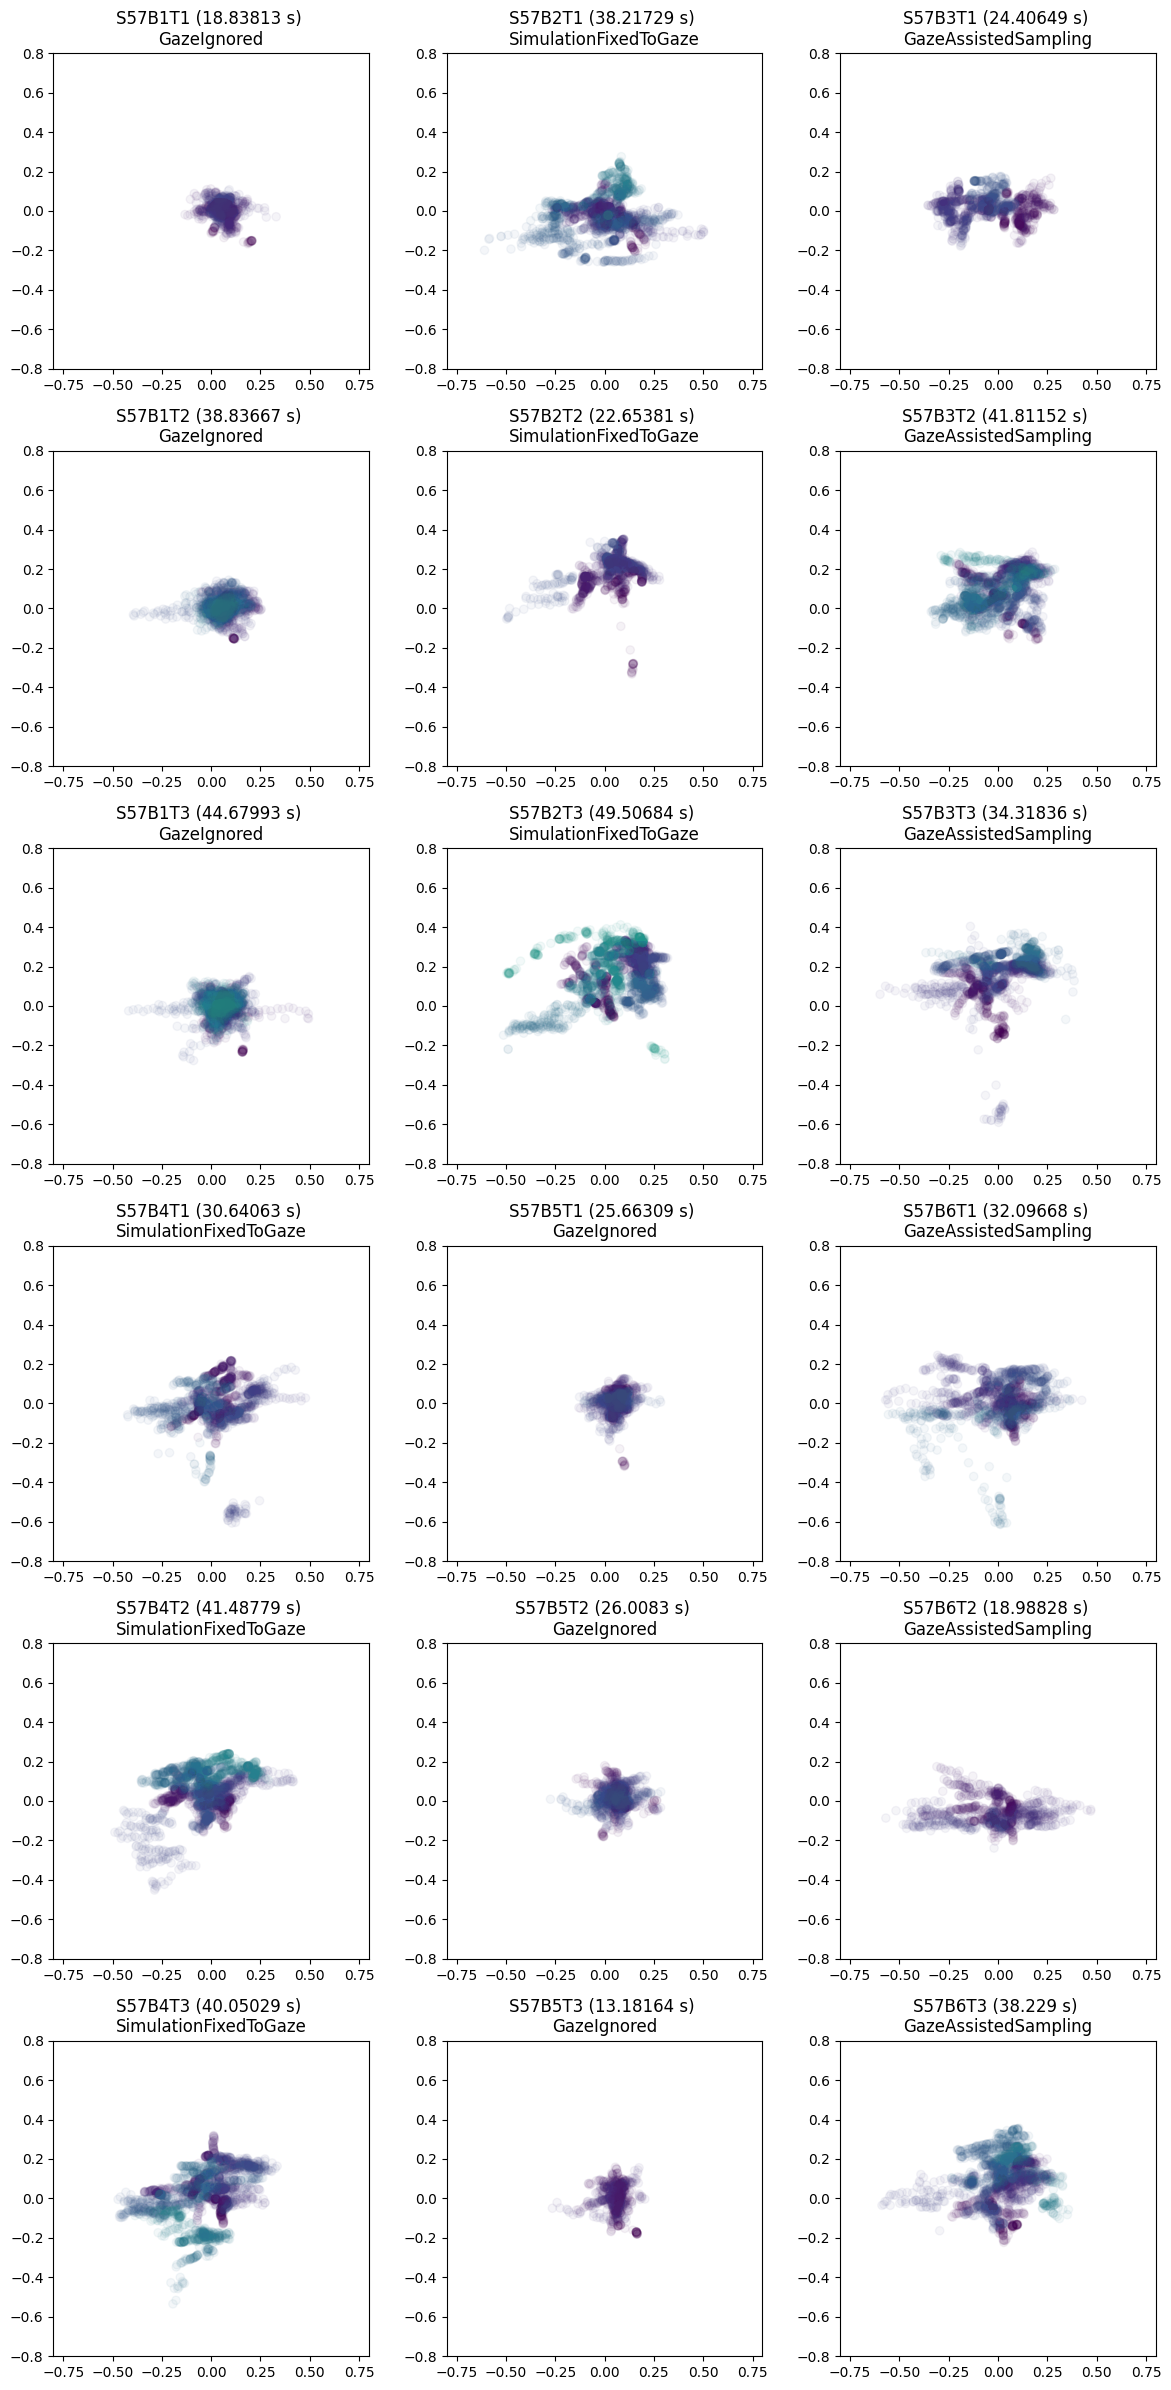

In [72]:
trials_of_interest = np.array([['S57B1T1', 'S57B2T1', 'S57B3T1'], 
                               ['S57B1T2', 'S57B2T2', 'S57B3T2'],
                               ['S57B1T3', 'S57B2T3', 'S57B3T3'],                               
                               ['S57B4T1', 'S57B5T1', 'S57B6T1'],
                               ['S57B4T2', 'S57B5T2', 'S57B6T2'],
                               ['S57B4T3', 'S57B5T3', 'S57B6T3'],])
plot_gaze_maps(trials_of_interest)
    


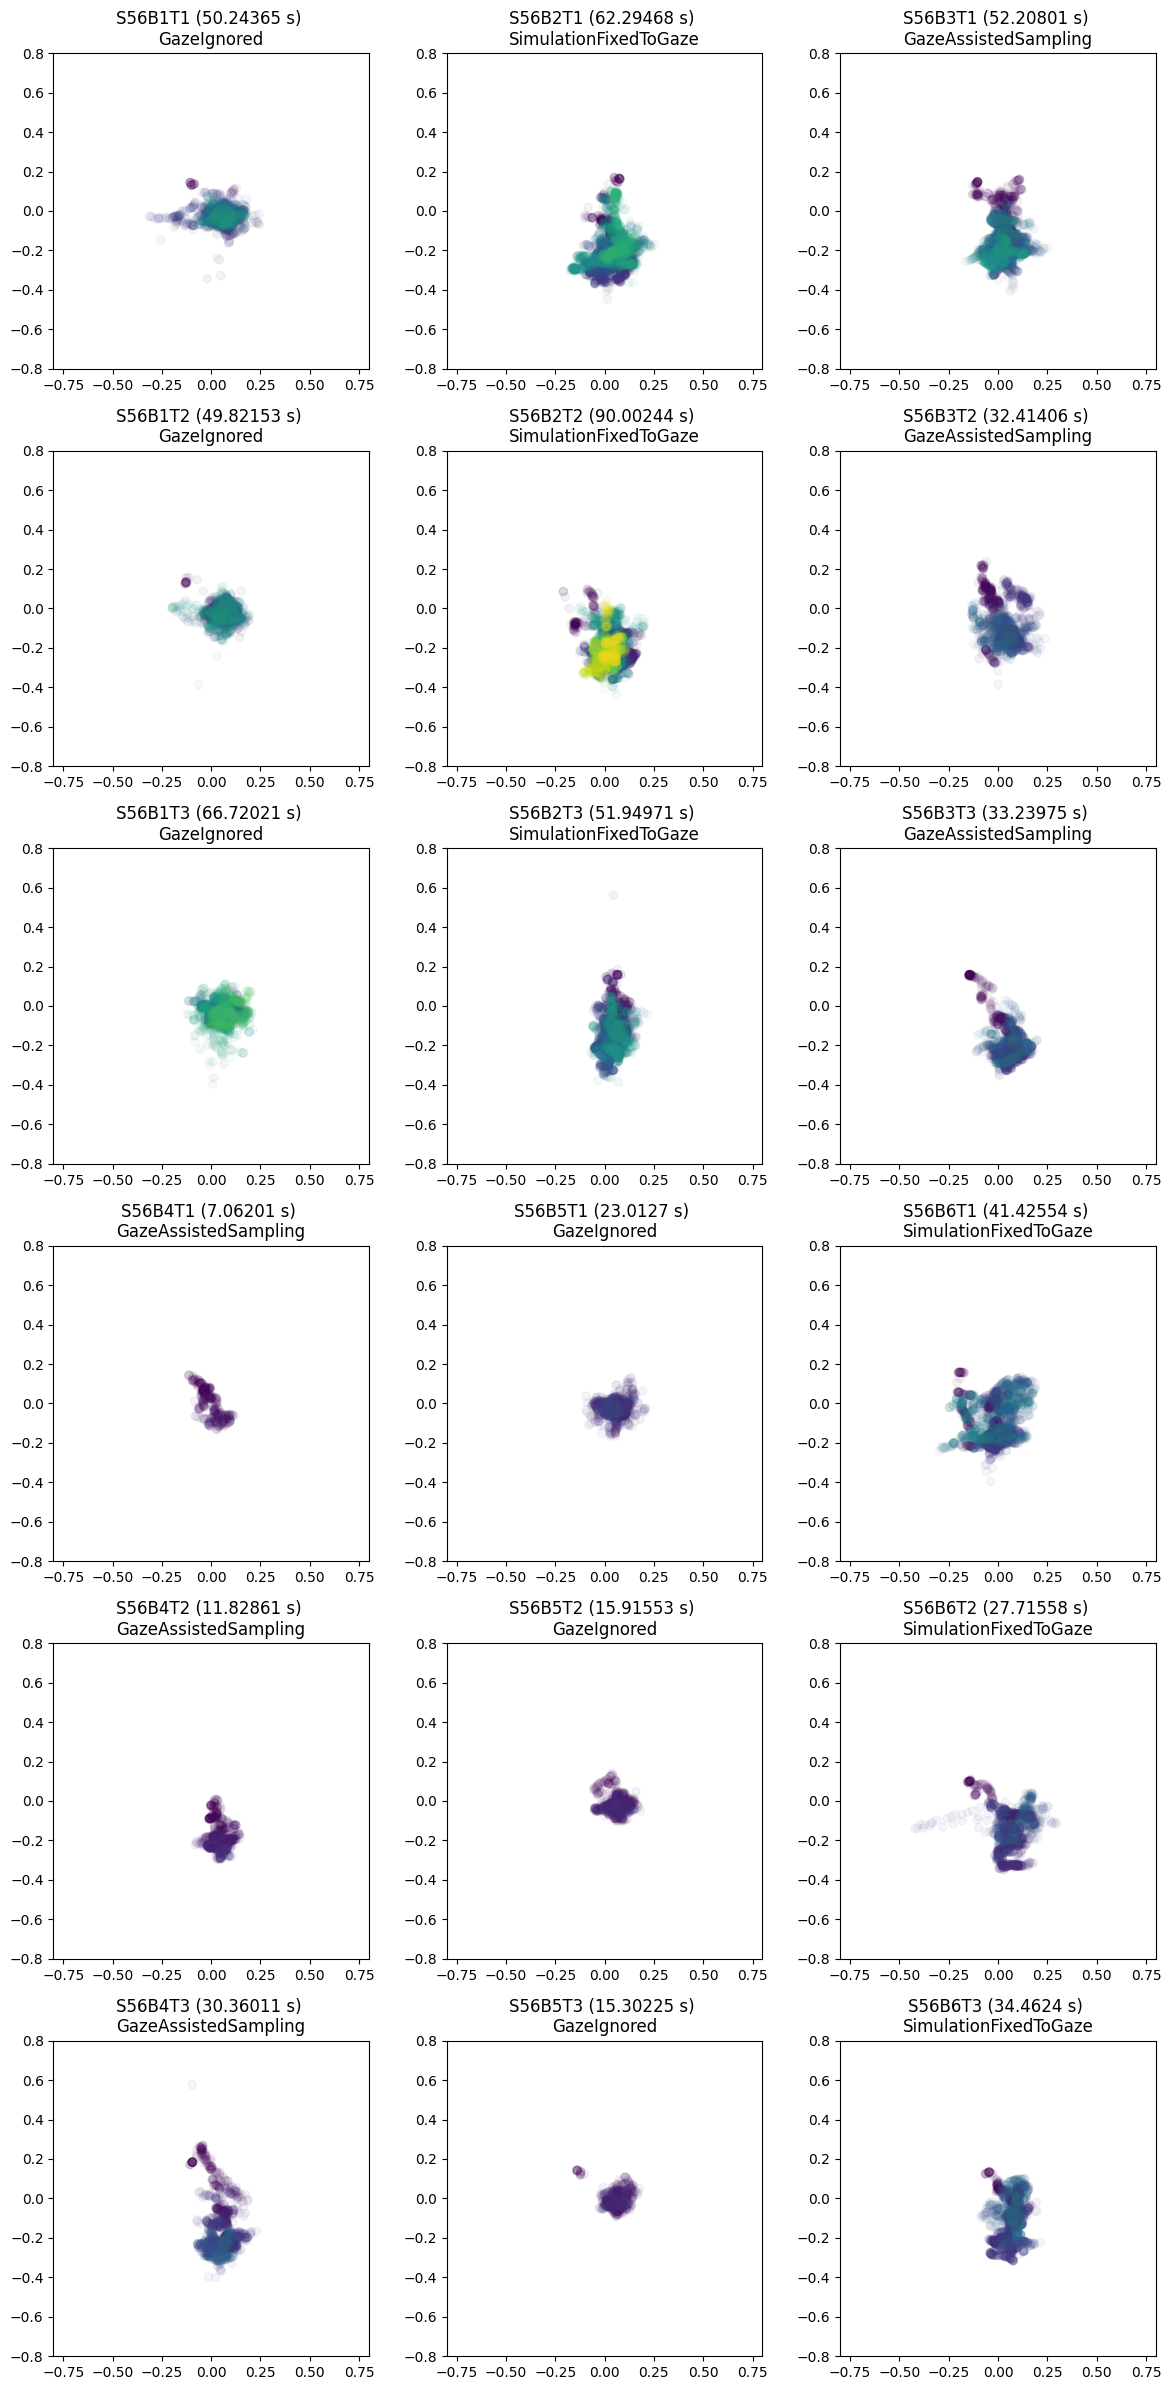

In [73]:
trials_of_interest = np.array([['S56B1T1', 'S56B2T1', 'S56B3T1'], 
                               ['S56B1T2', 'S56B2T2', 'S56B3T2'],
                               ['S56B1T3', 'S56B2T3', 'S56B3T3'],                               
                               ['S56B4T1', 'S56B5T1', 'S56B6T1'],
                               ['S56B4T2', 'S56B5T2', 'S56B6T2'],
                               ['S56B4T3', 'S56B5T3', 'S56B6T3'],])
plot_gaze_maps(trials_of_interest)
    


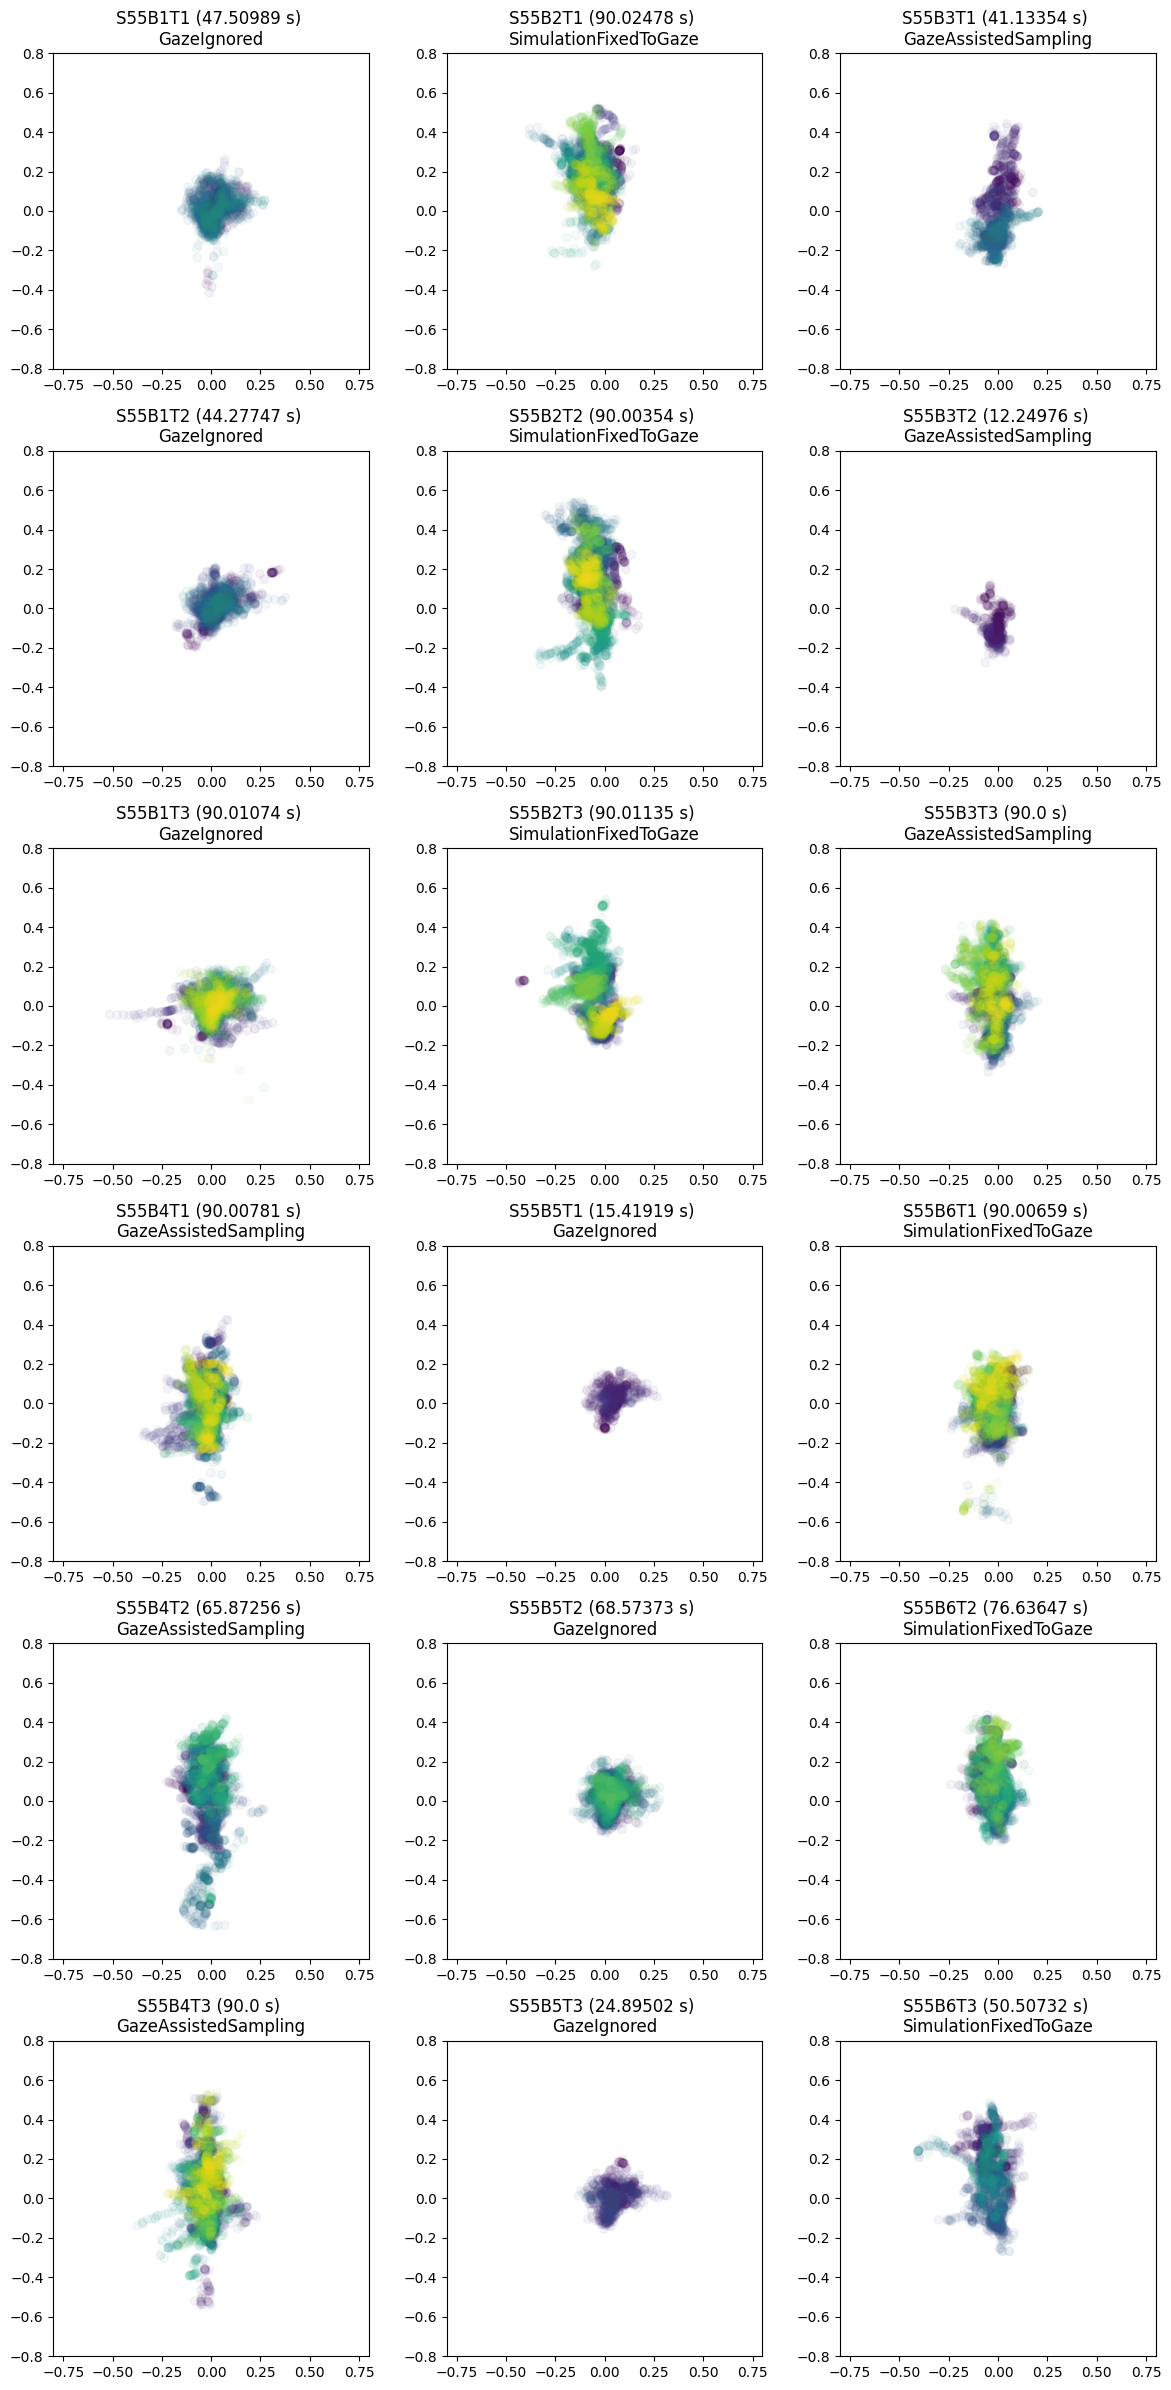

In [74]:
trials_of_interest = np.array([['S55B1T1', 'S55B2T1', 'S55B3T1'], 
                               ['S55B1T2', 'S55B2T2', 'S55B3T2'],
                               ['S55B1T3', 'S55B2T3', 'S55B3T3'],                               
                               ['S55B4T1', 'S55B5T1', 'S55B6T1'],
                               ['S55B4T2', 'S55B5T2', 'S55B6T2'],
                               ['S55B4T3', 'S55B5T3', 'S55B6T3'],])
plot_gaze_maps(trials_of_interest)
    

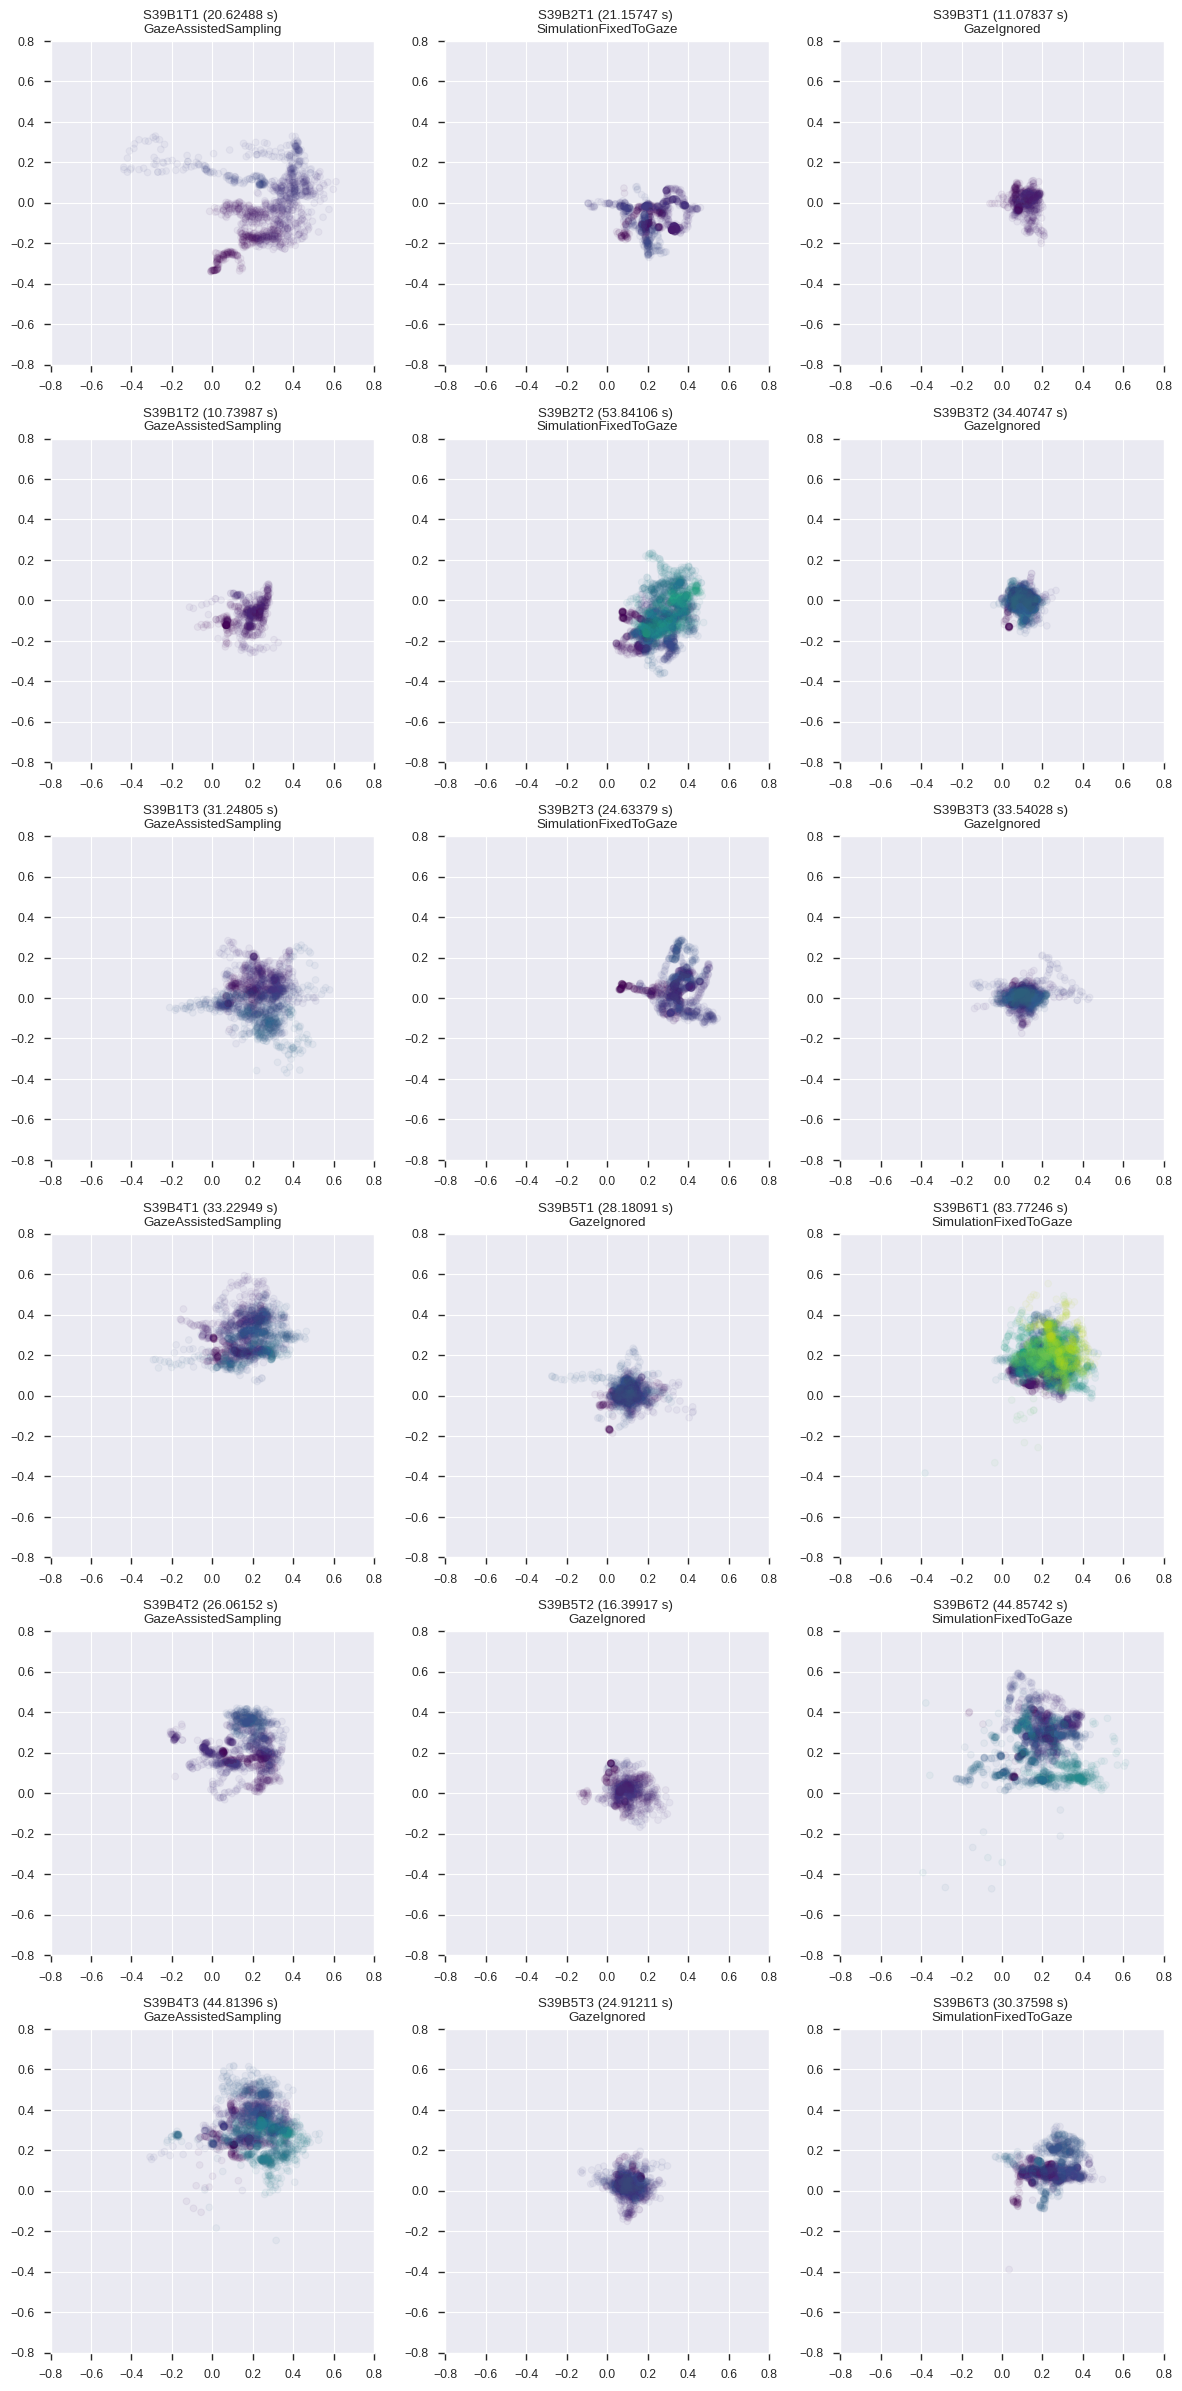

In [92]:
trials_of_interest = np.array([['S39B1T1', 'S39B2T1', 'S39B3T1'], 
                               ['S39B1T2', 'S39B2T2', 'S39B3T2'],
                               ['S39B1T3', 'S39B2T3', 'S39B3T3'],                               
                               ['S39B4T1', 'S39B5T1', 'S39B6T1'],
                               ['S39B4T2', 'S39B5T2', 'S39B6T2'],
                               ['S39B4T3', 'S39B5T3', 'S39B6T3'],])
plot_gaze_maps(trials_of_interest)